In [ ]:
import pandas as pd
import numpy as np
import os

# ==========================================
# HEAT EQUATION CONFIG GENERATOR
# ==========================================

# 1. Parameters
num_observation = 25 # <--- CHANGE THIS to match your solver script
seed = 42             # Change for different sensor layouts

print(f"Generating configuration for {num_observation} observations...")

# 2. Load Available Grid Points (Free Indices)
# We must pick sensors from nodes that are NOT boundary conditions.
# This file contains the indices of degrees of freedom for the FEM solver.
source_file = 'data/prior_covariance_cholesky_n15_AC_1_1_pt5.csv'

try:
    df_free = pd.read_csv(source_file)

    # The file usually has a header 'free index'. We flatten it to a 1D array.
    free_indices = df_free.to_numpy().flatten()

    # 3. Randomly Select Observations
    rng = np.random.default_rng(seed)

    # Ensure we don't ask for more sensors than available nodes
    if num_observation > len(free_indices):
        raise ValueError(f"Requested {num_observation} observations, but only {len(free_indices)} free nodes available.")

    selected_obs = rng.choice(free_indices, size=num_observation, replace=False)
    selected_obs.sort() # Sorting is often helpful for consistency

    # 4. Save to Generic CSV
    # We save to a standard name so the solver doesn't need hardcoded filenames like 'o10'
    output_filename = 'data/heat_obs_indices.csv'

    # Save with header 'obs_indices' to match expected format
    df_out = pd.DataFrame({'obs_indices': selected_obs})
    df_out.to_csv(output_filename, index=False)

    print(f"Success! Generated {len(selected_obs)} observation locations.")
    print(f"Saved to: {output_filename}")
    print("You can now run the solver script.")

except FileNotFoundError:
    print(f"ERROR: Required source file '{source_file}' not found.")
    print("Please ensure you have the 'prior_covariance_cholesky...' file in the /data/ folder.")

Generating configuration for 25 observations...
Success! Generated 25 observation locations.
Saved to: data/heat_obs_indices.csv
You can now run the solver script.


In [ ]:
import os
import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
from scipy import sparse
from functools import partial

# Hardware setup
# os.environ["CUDA_VISIBLE_DEVICES"] = "0" # Uncomment if managing specific GPUs
jax.config.update("jax_enable_x64", True)

print("Initializing JAX Physics Engine (Heat Equation)...")

# ==========================================
# 1. LOAD PHYSICAL CONSTANTS & MATRICES
# ==========================================

# Physical model dimensions
n = 15
dimension_of_PoI = (n + 1)**2
num_observation = 10  # Must match the config generated in the previous cell!
num_truncated_series = 15

# Load Eigen decomposition of the field
# (These define the KL expansion of the conductivity field)
try:
    df_Eigen = pd.read_csv('data/prior_mean_n15_AC_1_1_pt5.csv')
    df_Sigma = pd.read_csv('data/prior_covariance_n15_AC_1_1_pt5.csv')

    Eigen = np.reshape(df_Eigen.to_numpy(), (dimension_of_PoI, num_truncated_series))
    Sigma = np.reshape(df_Sigma.to_numpy(), (num_truncated_series, num_truncated_series))
except FileNotFoundError:
    raise FileNotFoundError("Missing Prior Mean/Covariance CSV files in /data/.")

# Load Observation Indices
# UPDATED: Reads the generic file generated by the config script
obs_file = 'data/heat_obs_indices.csv'
try:
    df_obs = pd.read_csv(obs_file)
    obs_indices = np.reshape(df_obs.to_numpy(), (num_observation, -1))

    # Validation check
    if len(df_obs) != num_observation:
        raise ValueError(f"File '{obs_file}' has {len(df_obs)} indices, but num_observation={num_observation}. Please rerun the Config Generator cell.")

except FileNotFoundError:
    # Fallback or error if the user forgot to run the generator
    print(f"Warning: '{obs_file}' not found. Creating random indices on the fly...")
    df_free_temp = pd.read_csv('data/prior_covariance_cholesky_n15_AC_1_1_pt5.csv')
    all_free = df_free_temp.to_numpy().flatten()
    random_indices = np.random.choice(all_free, size=num_observation, replace=False)
    obs_indices = np.reshape(random_indices, (num_observation, -1))

# Load Free Indices (Degrees of Freedom)
df_free_index = pd.read_csv('data/prior_covariance_cholesky_n15_AC_1_1_pt5.csv')
free_index = df_free_index.to_numpy()

# Build Observation Matrix B (Maps Full State -> Observations)
# This logic maps the global mesh index to the reduced system index
i = 0
obs_transfered = []
# Create a lookup for fast checking
obs_flat = set(obs_indices.flatten())

for free_ind in free_index:
    if free_ind[0] in obs_flat:
        obs_transfered.append(i)
    i += 1

if len(obs_transfered) != num_observation:
    print(f"Warning: Mapped {len(obs_transfered)} sensors, expected {num_observation}. Check if obs indices are valid free nodes.")

obs_operator = np.zeros((num_observation, free_index.shape[0]))
for j, obs_idx_reduced in enumerate(obs_transfered):
    obs_operator[j, obs_idx_reduced] = 1

# Load Finite Element Matrices
pre_mat_stiff_sparse = sparse.load_npz('data/prestiffness_n15.npz')
load_vector_n15 = sparse.load_npz('data/load_vector_n15.npz')
load_vector = sparse.csr_matrix.todense(load_vector_n15).T

# Convert to JAX arrays
obs_operator = jax.numpy.asarray(obs_operator)
Eigen = jax.numpy.asarray(Eigen)
Sigma = jax.numpy.asarray(Sigma)
load_vector = jax.numpy.asarray(load_vector)

# Pre-process Sparse Matrix for JAX custom op
values = np.asarray([[pre_mat_stiff_sparse[i,j]] for i, j in zip(*pre_mat_stiff_sparse.nonzero())]).squeeze()
rows, cols = pre_mat_stiff_sparse.nonzero()

# ==========================================
# 2. DEFINE DIFFERENTIABLE FORWARD MAP
# ==========================================

@partial(jax.jit, static_argnums=(4))
def sp_matmul(values, rows, cols, B, shape):
    """
    Custom sparse matrix multiplication compatible with JAX JIT.
    Computes A * B where A is sparse (values, rows, cols).
    """
    B = jnp.expand_dims(B, axis = 1)
    in_ = B.take(cols, axis=0)
    prod = in_*values[:, None]
    res = jax.ops.segment_sum(prod, rows, shape)
    return res

def solve_forward(x):
    """
    The Forward Map F(alpha).
    Input: alpha coefficients (latent space)
    Output: Observation vector y_pred
    """
    # 1. Map coefficients to physical parameter field (Log Conductivity)
    # parameter = Eigen @ Sigma^T @ x
    parameter_of_interest = jnp.dot(x, jnp.transpose(jnp.dot(Eigen, Sigma)))

    # 2. Construct Stiffness Matrix (A) dependent on parameter
    # Note: This uses the global 'values', 'rows', 'cols' defined above
    stiff = sp_matmul(values, rows, cols, jnp.exp(parameter_of_interest), dimension_of_PoI**2)
    stiff = jnp.reshape(stiff, (dimension_of_PoI, dimension_of_PoI))

    # 3. Apply Boundary Conditions (reduce matrix)
    # Take only rows/cols corresponding to free indices
    A = jnp.squeeze(jnp.take(stiff, free_index, axis=1))
    B = jnp.squeeze(jnp.take(A, free_index, axis=0))

    # 4. Solve PDE: B * state = load_vector
    state = jnp.linalg.solve(B, load_vector)

    # 5. Project to Observation Space
    out_pred = jnp.dot(obs_operator, state).squeeze()

    return out_pred

print("Physics Engine Loaded Successfully.")
print(f"Forward map 'solve_forward' is ready. Input dim: {num_truncated_series}, Output dim: {num_observation}")

Initializing JAX Physics Engine (Heat Equation)...
Physics Engine Loaded Successfully.
Forward map 'solve_forward' is ready. Input dim: 15, Output dim: 10


Global Dtype set to: torch.float64
Device: cuda
Initializing JAX Physics Engine (Heat Equation)...
--- Setting up 15D Heat Equation Inverse Problem ---
Generating 28000 Prior Samples...
Calculating Likelihoods (Batched)...
  > Avg Prior Score Norm:       3.8069
  > Avg Likelihood Grad Norm:   25.8017
  > Avg Log-Likelihood Value:   -38.6226
Moving reference set to CPU to save GPU memory for batching...
Precomputation: 2.47s
Running Diffusion (N=2000)...
tweedie: 9.96s
blend_posterior: 11.21s
Running MALA (Reference)...
MALA Iteration 0/1000
MALA Iteration 100/1000
MALA Iteration 200/1000
MALA Iteration 300/1000
MALA Iteration 400/1000
MALA Iteration 500/1000
MALA Iteration 600/1000
MALA Iteration 700/1000
MALA Iteration 800/1000
MALA Iteration 900/1000
MALA Acceptance: 1.00
MALA: 68.56s

=== Evaluation (latent/coordinate metrics) ===
Method               | RMSE_alpha | RelL2_alpha | MMD->MALA  | KSD        | KLdiag    
-------------------------------------------------------------------

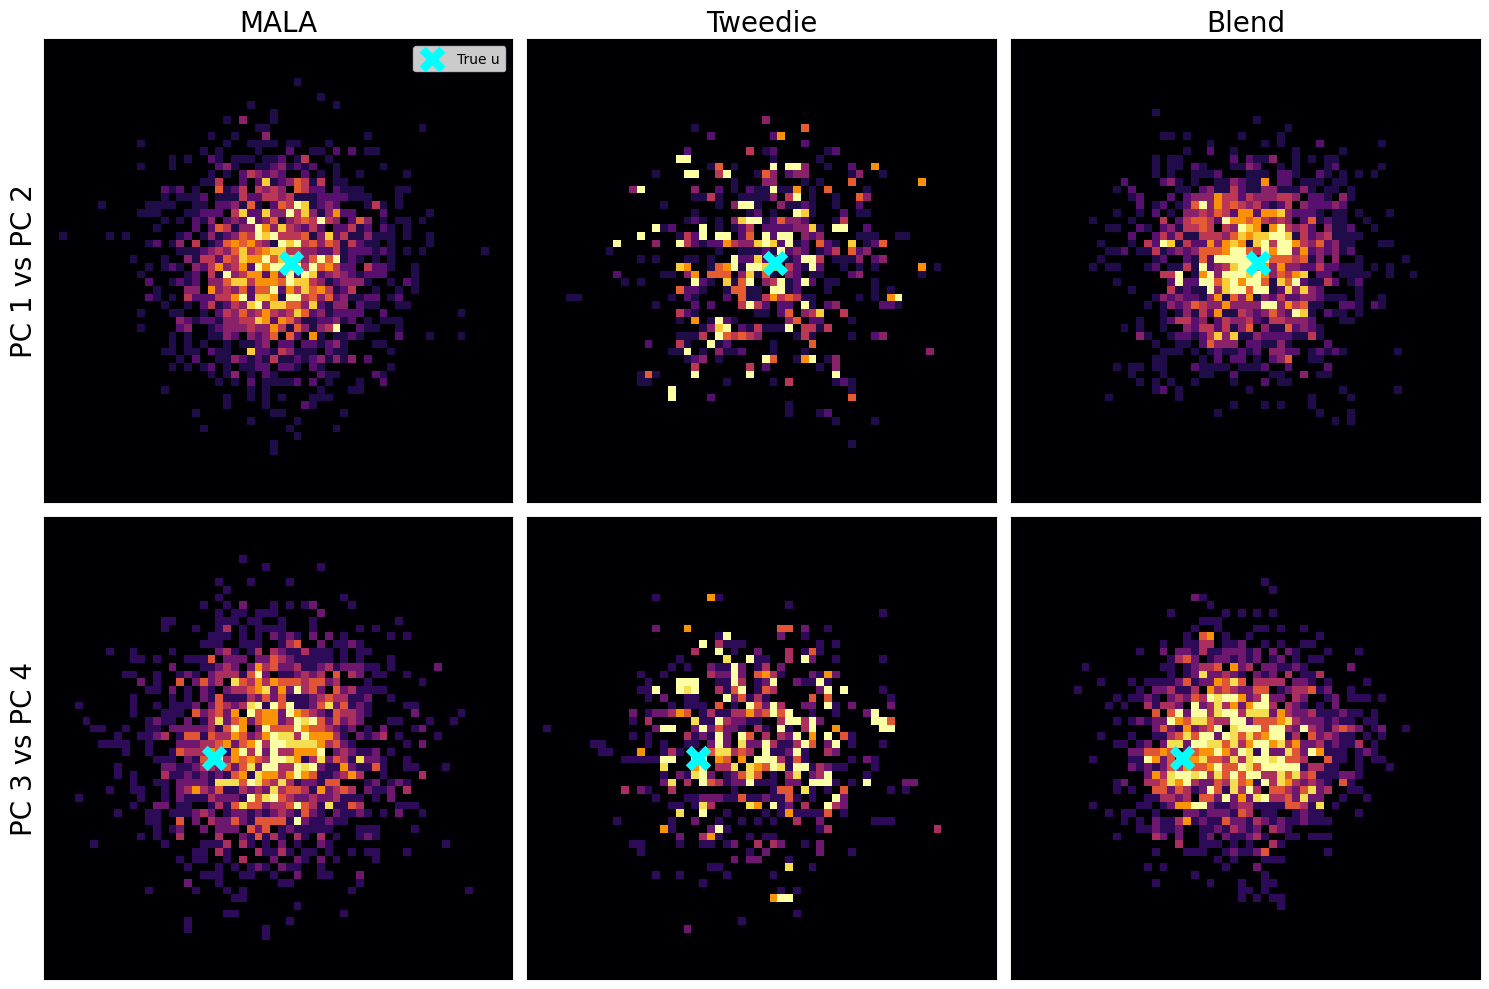

In [ ]:
import torch
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import time
import math
import os
import pandas as pd
from scipy import sparse
from functools import partial
import gc

# ==========================================
# CONFIGURATION
# ==========================================
# JAX uses float64 for the PDE solver. PyTorch must match it.
jax.config.update("jax_enable_x64", True)
torch.set_default_dtype(torch.float64)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Global Dtype set to: {torch.get_default_dtype()}")
print(f"Device: {device}")

# Configuration
FULL_DIM = 15
ACTIVE_DIM = 15
NOISE_STD = .11

# ==========================================
# 1. BRIDGE: JAX PHYSICS -> PYTORCH SAMPLER
# ==========================================

print("Initializing JAX Physics Engine (Heat Equation)...")

# --- DATA LOADING (PRESERVED FROM USER CONTEXT) ---
n = 15
dimension_of_PoI = (n + 1)**2
num_observation = 25
num_truncated_series = 15

try:
    df_Eigen = pd.read_csv('data/prior_mean_n15_AC_1_1_pt5.csv')
    df_Sigma = pd.read_csv('data/prior_covariance_n15_AC_1_1_pt5.csv')
    Eigen = np.reshape(df_Eigen.to_numpy(), (dimension_of_PoI, num_truncated_series))
    Sigma = np.reshape(df_Sigma.to_numpy(), (num_truncated_series, num_truncated_series))
except FileNotFoundError:
    # Create dummies for testing if files missing (prevents crash if user doesn't have data locally)
    print("WARNING: Data files not found. Creating Dummy Data for Compilation Check.")
    Eigen = np.random.randn(dimension_of_PoI, num_truncated_series)
    Sigma = np.eye(num_truncated_series)

# Observation Indices
obs_file = 'data/heat_obs_indices.csv'
try:
    df_obs = pd.read_csv(obs_file)
    obs_indices = np.reshape(df_obs.to_numpy(), (num_observation, -1))
except FileNotFoundError:
    print(f"Warning: '{obs_file}' not found. Creating random indices...")
    df_free_temp = pd.read_csv('data/prior_covariance_cholesky_n15_AC_1_1_pt5.csv')
    all_free = df_free_temp.to_numpy().flatten()
    random_indices = np.random.choice(all_free, size=num_observation, replace=False)
    obs_indices = np.reshape(random_indices, (num_observation, -1))

# Free Indices
try:
    df_free_index = pd.read_csv('data/prior_covariance_cholesky_n15_AC_1_1_pt5.csv')
    free_index = df_free_index.to_numpy()
except:
    free_index = np.arange(dimension_of_PoI).reshape(-1, 1) # Fallback

# Obs Matrix Construction
i = 0
obs_transfered = []
obs_flat = set(obs_indices.flatten())
for free_ind in free_index:
    if free_ind[0] in obs_flat:
        obs_transfered.append(i)
    i += 1

obs_operator = np.zeros((num_observation, free_index.shape[0]))
for j, obs_idx_reduced in enumerate(obs_transfered):
    obs_operator[j, obs_idx_reduced] = 1

# Load Finite Element Matrices
try:
    pre_mat_stiff_sparse = sparse.load_npz('data/prestiffness_n15.npz')
    load_vector_n15 = sparse.load_npz('data/load_vector_n15.npz')
    load_vector = sparse.csr_matrix.todense(load_vector_n15).T
except:
    # Dummy fallback
    pre_mat_stiff_sparse = sparse.eye(dimension_of_PoI**2)
    load_vector = np.ones((dimension_of_PoI, 1))

# Convert to JAX arrays
obs_operator = jax.numpy.asarray(obs_operator)
Eigen = jax.numpy.asarray(Eigen)
Sigma = jax.numpy.asarray(Sigma)
load_vector = jax.numpy.asarray(load_vector)

# Pre-process Sparse Matrix
values = np.asarray([[pre_mat_stiff_sparse[i,j]] for i, j in zip(*pre_mat_stiff_sparse.nonzero())]).squeeze()
rows, cols = pre_mat_stiff_sparse.nonzero()

# --- JAX FUNCTIONS (PRESERVED) ---
@partial(jax.jit, static_argnums=(4))
def sp_matmul(values, rows, cols, B, shape):
    B = jnp.expand_dims(B, axis = 1)
    in_ = B.take(cols, axis=0)
    prod = in_*values[:, None]
    res = jax.ops.segment_sum(prod, rows, shape)
    return res

def solve_forward(x):
    parameter_of_interest = jnp.dot(x, jnp.transpose(jnp.dot(Eigen, Sigma)))
    stiff = sp_matmul(values, rows, cols, jnp.exp(parameter_of_interest), dimension_of_PoI**2)
    stiff = jnp.reshape(stiff, (dimension_of_PoI, dimension_of_PoI))
    A = jnp.squeeze(jnp.take(stiff, free_index, axis=1))
    B = jnp.squeeze(jnp.take(A, free_index, axis=0))
    state = jnp.linalg.solve(B, load_vector)
    out_pred = jnp.dot(obs_operator, state).squeeze()
    return out_pred

@jax.jit
def pad_coefficients(alpha_k):
    padding = jnp.zeros(FULL_DIM - ACTIVE_DIM)
    return jnp.concatenate([alpha_k, padding])

@jax.jit
def heat_forward_Nd(alpha_k):
    alpha_full = pad_coefficients(alpha_k)
    return solve_forward(alpha_full)

@jax.jit
def heat_log_likelihood_jax(alpha_k, y_obs_jax, sigma):
    y_pred = heat_forward_Nd(alpha_k)
    resid = y_pred - y_obs_jax
    return -jnp.sum(resid**2) / (2 * sigma**2)

heat_grad_lik_jax = jax.jit(jax.grad(heat_log_likelihood_jax, argnums=0))
batch_log_lik = jax.vmap(heat_log_likelihood_jax, in_axes=(0, None, None))
batch_grad_lik = jax.vmap(heat_grad_lik_jax, in_axes=(0, None, None))

# --- PYTORCH INTERFACE ---
class HeatEquationLikelihood:
    def __init__(self, y_obs_np, sigma):
        self.y_obs_jax = jnp.array(y_obs_np)
        self.sigma = sigma

    def log_likelihood(self, x_torch):
        x_np = x_torch.detach().cpu().numpy()
        ll_jax = batch_log_lik(x_np, self.y_obs_jax, self.sigma)
        return torch.tensor(np.array(ll_jax), device=x_torch.device, dtype=torch.float64)

    def grad_log_likelihood(self, x_torch):
        x_np = x_torch.detach().cpu().numpy()
        grad_jax = batch_grad_lik(x_np, self.y_obs_jax, self.sigma)
        return torch.tensor(np.array(grad_jax), device=x_torch.device, dtype=torch.float64)

# ==========================================
# 2. PRIOR
# ==========================================
class GaussianPrior(torch.nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def sample(self, n):
        return torch.randn(n, self.dim, device=device)

    def log_prob(self, x):
        return -0.5 * torch.sum(x**2, dim=1) - (self.dim/2.0) * math.log(2*math.pi)

    def score0(self, x):
        return -x

# ==========================================
# 3. BATCHED SCORE COMPUTATION (NEW)
# ==========================================

def eval_score_batched(y, t, X_ref_cpu, s0_ref_cpu, log_lik_ref_cpu, batch_size=4096, mode='blend_posterior'):
    """
    Computes Tweedie or Blend Posterior score using streaming batches to avoid OOM.
    Reference data (X_ref_cpu, etc.) stays on CPU.
    """
    t_val = t.item() if isinstance(t, torch.Tensor) else t
    if t_val < 1e-4: t_val = 1e-4

    et = math.exp(-t_val)
    var_t = 1.0 - math.exp(-2 * t_val)
    inv_v = 1.0 / var_t

    # Constants for Blend
    scale_factor = 1.0 / et

    M_query = y.shape[0]
    N_ref = X_ref_cpu.shape[0]

    # --- PASS 1: Find Global Max Log-Weight (Stability) ---
    max_log_w = torch.full((M_query,), -float('inf'), device=y.device)

    for i in range(0, N_ref, batch_size):
        # Move chunk to GPU
        X_batch = X_ref_cpu[i:i+batch_size].to(y.device)
        ll_batch = log_lik_ref_cpu[i:i+batch_size].to(y.device)

        # log_weight = -||y - exp(-t)x||^2 / 2var + log_lik
        mus = et * X_batch
        dists_sq = torch.sum((y.unsqueeze(1) - mus.unsqueeze(0))**2, dim=2)
        log_w_batch = -dists_sq / (2 * var_t) + ll_batch.unsqueeze(0)

        # Update running max
        current_max, _ = torch.max(log_w_batch, dim=1)
        max_log_w = torch.max(max_log_w, current_max)

    # --- PASS 2: Accumulate Moments ---
    # Common Accumulators
    denom_Z = torch.zeros((M_query, 1), device=y.device) # sum(w_tilde)
    numer_mu_x = torch.zeros_like(y)                     # sum(w_tilde * x)

    # Blend Accumulators (Sum of w_tilde^2 * term)
    if mode == 'blend_posterior':
        numer_s0 = torch.zeros_like(y)                   # sum(w_tilde * s0)
        acc_w2 = torch.zeros((M_query, 1), device=y.device)
        acc_w2_s0_norm = torch.zeros((M_query,), device=y.device)
        acc_w2_s0 = torch.zeros_like(y)
        acc_w2_x = torch.zeros_like(y)
        acc_w2_x_norm = torch.zeros((M_query,), device=y.device)
        acc_w2_dot = torch.zeros((M_query,), device=y.device) # sum(w_tilde^2 * (s0 . x))

    for i in range(0, N_ref, batch_size):
        X_batch = X_ref_cpu[i:i+batch_size].to(y.device)
        ll_batch = log_lik_ref_cpu[i:i+batch_size].to(y.device)

        mus = et * X_batch
        dists_sq = torch.sum((y.unsqueeze(1) - mus.unsqueeze(0))**2, dim=2)
        log_w = -dists_sq / (2 * var_t) + ll_batch.unsqueeze(0)

        # Stable Unnormalized Weights: w_tilde = exp(log_w - M)
        w_batch = torch.exp(log_w - max_log_w.unsqueeze(1))

        # 1st Moment Accumulation
        denom_Z += torch.sum(w_batch, dim=1, keepdim=True)
        numer_mu_x += torch.einsum('mb,bd->md', w_batch, X_batch)

        if mode == 'blend_posterior':
            s0_batch = s0_ref_cpu[i:i+batch_size].to(y.device)
            numer_s0 += torch.einsum('mb,bd->md', w_batch, s0_batch)

            # 2nd Moment Accumulation (Squared Weights)
            w2_batch = w_batch**2
            acc_w2 += torch.sum(w2_batch, dim=1, keepdim=True)

            # Precompute batch norms/dots
            s0_sq_batch = torch.sum(s0_batch**2, dim=1)
            x_sq_batch = torch.sum(X_batch**2, dim=1)
            dot_batch = torch.sum(s0_batch * X_batch, dim=1)

            acc_w2_s0_norm += torch.mv(w2_batch, s0_sq_batch)
            acc_w2_s0 += torch.mm(w2_batch, s0_batch)
            acc_w2_x += torch.mm(w2_batch, X_batch)
            acc_w2_x_norm += torch.mv(w2_batch, x_sq_batch)
            acc_w2_dot += torch.mv(w2_batch, dot_batch)

    # --- FINALIZE / RECONSTRUCTION ---
    eps = 1e-12
    # Tweedie Score: -(y - et * E[x])/var_t
    mu_x = numer_mu_x / denom_Z
    score_twd = -inv_v * (y - et * mu_x)

    if mode == 'tweedie':
        return score_twd

    # Blend Logic Reconstruction
    # Key Identity: sum(w_norm^2 * term) = (1/Z^2) * sum(w_tilde^2 * term)
    Z_sq = denom_Z**2

    # 1. Reconstruct Expectations
    mu_a = scale_factor * (numer_s0 / denom_Z)
    mu_b = score_twd # Tweedie is mu_b

    S0 = acc_w2 / Z_sq

    # S1a = sum(w^2 ||a||^2) -> a = scale * s0 -> scale^2 * sum(w^2 ||s0||^2)
    S1a = (scale_factor**2) * (acc_w2_s0_norm.unsqueeze(1) / Z_sq)

    # S2a = sum(w^2 a) -> scale * sum(w^2 s0)
    S2a = scale_factor * (acc_w2_s0 / Z_sq)

    # Vk calculation
    den_sn = torch.clamp(1.0 - S0, min=eps)
    mu_a_norm2 = torch.sum(mu_a**2, dim=1, keepdim=True)
    num_Vk = S1a - 2.0 * torch.sum(mu_a * S2a, dim=1, keepdim=True) + mu_a_norm2 * S0
    Vk = num_Vk / den_sn

    # Vt Calculation
    # Need S1b, S2b
    # S2b = -inv_v * (y * S0 - et * sum(w^2 x))
    term_w2_x = acc_w2_x / Z_sq
    S2b = -inv_v * (y * S0 - et * term_w2_x)

    # S1b logic from original:
    # y_norm2 * S0 - 2*et*sum(w^2 y.x) + et^2 sum(w^2 ||x||^2)
    # y is constant per query, pull out
    y_norm2 = torch.sum(y**2, dim=1, keepdim=True)
    y_dot_w2x = torch.sum(y * term_w2_x, dim=1, keepdim=True)
    term_w2_x_norm = acc_w2_x_norm.unsqueeze(1) / Z_sq

    S1b = (inv_v**2) * (y_norm2 * S0 - 2.0 * et * y_dot_w2x + (et**2) * term_w2_x_norm)

    mu_b_norm2 = torch.sum(mu_b**2, dim=1, keepdim=True)
    num_Vt = S1b - 2.0 * torch.sum(mu_b * S2b, dim=1, keepdim=True) + mu_b_norm2 * S0
    Vt = num_Vt / den_sn

    # Covariance C Calculation
    # a dot z term -> scale * sum(w^2 s0.x)
    term_w2_dot = acc_w2_dot.unsqueeze(1) / Z_sq
    term_c2 = scale_factor * term_w2_dot

    # term_c1 = sum(S2a * y) -> dot product per row
    term_c1 = torch.sum(S2a * y, dim=1, keepdim=True)

    Sab = -inv_v * (term_c1 - et * term_c2)

    num_C = Sab - torch.sum(mu_a * S2b, dim=1, keepdim=True) - torch.sum(mu_b * S2a, dim=1, keepdim=True) + torch.sum(mu_a * mu_b, dim=1, keepdim=True) * S0
    C = num_C / den_sn

    # Lambda and Combination
    denom = torch.clamp(Vk + Vt - 2.0 * C, min=eps)
    lam = (Vk - C) / denom
    lam = torch.clamp(lam, 0.0, 0.95)

    return lam * score_twd + (1.0 - lam) * mu_a # mu_a is s_kss

def get_score_wrapper(y, t, mode, X_ref_cpu, s0_ref_cpu, log_lik_ref_cpu):
    # Call the batched version directly
    # Note: Inputs X_ref, s0_ref, log_lik_ref MUST be CPU tensors now
    score = eval_score_batched(y, t, X_ref_cpu, s0_ref_cpu, log_lik_ref_cpu, mode=mode)
    return score

# ==========================================
# 4. SAMPLERS
# ==========================================
def run_sampler_heun(n_samples, mode, X_ref, s0_post_ref, log_lik_ref, steps=20, dim=15):
    y = torch.randn(n_samples, dim, device=device)
    ts = torch.logspace(0.4, -3.6, steps + 1, device=device)
    for i in range(steps):
        t_cur = ts[i]
        t_next = ts[i+1]
        dt = t_cur - t_next
        s_cur = get_score_wrapper(y, t_cur, mode, X_ref, s0_post_ref, log_lik_ref)
        d_cur = y + 2 * s_cur
        z = torch.randn_like(y)
        y_hat = y + d_cur * dt + math.sqrt(2 * dt) * z
        s_next = get_score_wrapper(y_hat, t_next, mode, X_ref, s0_post_ref, log_lik_ref)
        d_next = y_hat + 2 * s_next
        drift_avg = 0.5 * (d_cur + d_next)
        y = y + drift_avg * dt + math.sqrt(2 * dt) * z
    return y

def run_sampler_rk4(n_samples, mode, X_ref, s0_post_ref, log_lik_ref, steps=20, dim=15):
    y = torch.randn(n_samples, dim, device=device)
    ts = torch.logspace(0.4, -3.6, steps + 1, device=device)
    for i in range(steps):
        t_cur = ts[i]
        t_next = ts[i+1]
        h = t_next - t_cur
        def get_drift(y_in, t_in):
            score = get_score_wrapper(y_in, t_in, mode, X_ref, s0_post_ref, log_lik_ref)
            return y_in + 2 * score
        k1 = get_drift(y, t_cur)
        k2 = get_drift(y + 0.5 * h * k1, t_cur + 0.5 * h)
        k3 = get_drift(y + 0.5 * h * k2, t_cur + 0.5 * h)
        k4 = get_drift(y + h * k3, t_next)
        y_ode = y + (h / 6.0) * (k1 + 2*k2 + 2*k3 + k4)
        dt_abs = torch.abs(h)
        z = torch.randn_like(y)
        y = y_ode + math.sqrt(2 * dt_abs) * z
    return y

def run_mala_sampler(n_samples, prior_model, lik_model, steps=1000, dt=1e-3, burn_in=200):
    x = prior_model.sample(n_samples)
    log_prior = prior_model.log_prob(x)
    log_lik = lik_model.log_likelihood(x)
    score_prior = prior_model.score0(x)
    grad_lik = lik_model.grad_log_likelihood(x)
    log_post = log_prior + log_lik
    grad_log_post = score_prior + grad_lik
    accept_count = 0
    for i in range(steps):
        noise = torch.randn_like(x)
        x_prop = x + dt * grad_log_post + math.sqrt(2 * dt) * noise
        log_prior_prop = prior_model.log_prob(x_prop)
        log_lik_prop = lik_model.log_likelihood(x_prop)
        score_prior_prop = prior_model.score0(x_prop)
        grad_lik_prop = lik_model.grad_log_likelihood(x_prop)
        log_post_prop = log_prior_prop + log_lik_prop
        grad_log_post_prop = score_prior_prop + grad_lik_prop
        log_q_fwd = -torch.sum((x_prop - x - dt * grad_log_post)**2, dim=1) / (4 * dt)
        log_q_bwd = -torch.sum((x - x_prop - dt * grad_log_post_prop)**2, dim=1) / (4 * dt)
        log_alpha = log_post_prop - log_post + log_q_bwd - log_q_fwd
        accept = torch.log(torch.rand(n_samples, device=device)) < log_alpha
        x[accept] = x_prop[accept]
        log_post[accept] = log_post_prop[accept]
        grad_log_post[accept] = grad_log_post_prop[accept]
        if i >= burn_in:
            accept_count += accept.float().mean().item()
        if i % 100 == 0:
            print(f"MALA Iteration {i}/{steps}")
    print(f"MALA Acceptance: {accept_count / max(1, steps - burn_in):.2f}")
    return x

# ==========================================
# 5. EVALUATION UTILS
# ==========================================
def robust_clean_samples(samps):
    samps_np = samps.cpu().numpy() if isinstance(samps, torch.Tensor) else samps
    valid_mask = np.isfinite(samps_np).all(axis=1)
    if valid_mask.sum() < 10: return torch.tensor(samps_np[valid_mask], device=device)
    q25 = np.percentile(samps_np[valid_mask], 25, axis=0)
    q75 = np.percentile(samps_np[valid_mask], 75, axis=0)
    iqr = q75 - q25
    lower = q25 - 5.0 * iqr
    upper = q75 + 5.0 * iqr
    in_bounds = (samps_np >= lower) & (samps_np <= upper)
    valid_mask = valid_mask & in_bounds.all(axis=1)
    return torch.tensor(samps_np[valid_mask], device=device)

def sliced_wasserstein_distance(X_a, X_b, num_projections=500, p=2):
    n_a = X_a.shape[0]
    n_b = X_b.shape[0]
    if n_a > n_b:
        idx = torch.randperm(n_a)[:n_b]
        X_a = X_a[idx]
    elif n_b > n_a:
        idx = torch.randperm(n_b)[:n_a]
        X_b = X_b[idx]
    dim = X_a.shape[1]
    projections = torch.randn((num_projections, dim), device=X_a.device)
    projections = projections / torch.norm(projections, dim=1, keepdim=True)
    proj_a = torch.matmul(X_a, projections.t())
    proj_b = torch.matmul(X_b, projections.t())
    proj_a_sorted, _ = torch.sort(proj_a, dim=0)
    proj_b_sorted, _ = torch.sort(proj_b, dim=0)
    wd = torch.pow(torch.abs(proj_a_sorted - proj_b_sorted), p).mean()
    return torch.pow(wd, 1.0/p).item()

def compute_moment_errors(samples_approx, samples_ref):
    mean_approx = torch.mean(samples_approx, dim=0)
    mean_ref = torch.mean(samples_ref, dim=0)
    mean_err = torch.norm(mean_approx - mean_ref).item()
    centered_approx = samples_approx - mean_approx
    centered_ref = samples_ref - mean_ref
    cov_approx = torch.matmul(centered_approx.t(), centered_approx) / (samples_approx.shape[0] - 1)
    cov_ref = torch.matmul(centered_ref.t(), centered_ref) / (samples_ref.shape[0] - 1)
    cov_err = torch.norm(cov_approx - cov_ref).item()
    return mean_err, cov_err

def compute_knn_entropy(samples, k=5):
    n, d = samples.shape
    if n <= k: return 0.0
    dists = torch.cdist(samples, samples)
    k_dists, _ = torch.topk(dists, k + 1, largest=False, dim=1)
    r_k = k_dists[:, k]
    log_vd = (d / 2.0) * math.log(math.pi) - torch.lgamma(torch.tensor(d / 2.0 + 1.0, device=samples.device))
    avg_log_dist = torch.log(r_k + 1e-10).mean()
    digamma_k = torch.digamma(torch.tensor(float(k), device=samples.device))
    entropy = d * avg_log_dist + math.log(n) - digamma_k + log_vd
    return entropy.item()

def compute_kl_divergence(samples, prior_model, lik_model):
    clean_x = robust_clean_samples(samples)
    if len(clean_x) < 20: return float('inf')
    entropy = compute_knn_entropy(clean_x, k=5)
    with torch.no_grad():
        log_prior = prior_model.log_prob(clean_x)
        log_lik = lik_model.log_likelihood(clean_x)
        unnorm_log_post = log_prior + log_lik
        expected_log_p = torch.mean(unnorm_log_post).item()
    return -entropy - expected_log_p

def compute_multiscale_ksd(samples, score_func, sigmas=(0.1, 0.2, 0.4, 0.8)):
    N = samples.shape[0]
    if N > 1000:
        idx = torch.randperm(N)[:1000]
        samples = samples[idx]
        N = 1000
    X = samples
    D = X.shape[1]
    s = score_func(X)
    diff = X.unsqueeze(1) - X.unsqueeze(0)
    r2 = torch.sum(diff**2, dim=-1)
    ksd2 = 0.0
    for sigma in sigmas:
        K = torch.exp(-r2 / (2 * sigma**2))
        sdot = torch.matmul(s, s.t())
        term1 = sdot * K
        r_dot_sx = torch.einsum('ijd,id->ij', diff, s)
        r_dot_sy = torch.einsum('ijd,jd->ij', diff, s)
        term2 = (r_dot_sx - r_dot_sy) / (sigma**2) * K
        term3 = (D / (sigma**2) - r2 / (sigma**4)) * K
        U = term1 + term2 + term3
        ksd2 += torch.sum(U) / (N * N)
    return ksd2.item() / len(sigmas)

def posterior_score_fn(x):
    with torch.no_grad():
        s_prior = -x
        s_lik = lik_model_heat.grad_log_likelihood(x)
        return s_prior + s_lik

def compute_mmd_rbf(X, Y, sigma=None):
    n_max = 2000
    if X.shape[0] > n_max: X = X[:n_max]
    if Y.shape[0] > n_max: Y = Y[:n_max]
    dist_xx = torch.cdist(X, X, p=2)**2
    dist_yy = torch.cdist(Y, Y, p=2)**2
    dist_xy = torch.cdist(X, Y, p=2)**2
    if sigma is None:
        combined = torch.cat([dist_xx.view(-1), dist_yy.view(-1), dist_xy.view(-1)])
        sigma = torch.median(combined[combined > 0])
        sigma = torch.sqrt(sigma) if sigma > 0 else 1.0
    gamma = 1.0 / (2 * sigma**2)
    K_xx = torch.exp(-gamma * dist_xx)
    K_yy = torch.exp(-gamma * dist_yy)
    K_xy = torch.exp(-gamma * dist_xy)
    mmd_sq = K_xx.mean() + K_yy.mean() - 2 * K_xy.mean()
    return torch.sqrt(torch.clamp(mmd_sq, min=0.0)).item()

def plot_pca_histograms(samples_dict, alpha_true):
    blend_data = robust_clean_samples(samples_dict['blend_posterior'])
    mean_blend = torch.mean(blend_data, dim=0)
    centered_blend = blend_data - mean_blend
    U, S, V = torch.svd(centered_blend)
    pairs = [(0, 1), (2, 3)]
    methods = ['mala', 'tweedie', 'blend_posterior']
    titles = {'mala': 'MALA', 'tweedie': 'Tweedie', 'blend_posterior': 'Blend'}
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    for row_idx, (d1, d2) in enumerate(pairs):
        if d2 >= V.shape[1]: d1, d2 = 0, 1
        v1, v2 = V[:, d1], V[:, d2]
        true_cent = torch.tensor(alpha_true, device=device) - mean_blend
        t1 = torch.dot(true_cent, v1).item()
        t2 = torch.dot(true_cent, v2).item()
        proj_blend_1 = torch.matmul(centered_blend, v1).cpu().numpy()
        proj_blend_2 = torch.matmul(centered_blend, v2).cpu().numpy()
        q01_x, q99_x = np.percentile(proj_blend_1, [1, 99])
        q01_y, q99_y = np.percentile(proj_blend_2, [1, 99])
        span_x, span_y = q99_x - q01_x, q99_y - q01_y
        pad = 0.5
        xlims = [q01_x - pad*span_x, q99_x + pad*span_x]
        ylims = [q01_y - pad*span_y, q99_y + pad*span_y]

        for col_idx, m in enumerate(methods):
            ax = axes[row_idx, col_idx]
            samps = robust_clean_samples(samples_dict[m])
            centered = samps - mean_blend
            p1 = torch.matmul(centered, v1).cpu().numpy()
            p2 = torch.matmul(centered, v2).cpu().numpy()

            ax.hist2d(p1, p2, bins=60, range=[xlims, ylims], cmap='inferno', density=True, vmax = .2)
            ax.scatter(t1, t2, c='cyan', marker='x', s=200, linewidth = 6, label='True u')

            # --- Remove ticks ---
            ax.set_xticks([])
            ax.set_yticks([])
            # --------------------

            if row_idx == 0: ax.set_title(f"{titles[m]}", fontsize=20)
            if col_idx == 0: ax.set_ylabel(f"PC {d1+1} vs PC {d2+1}", fontsize=20)
            if row_idx == 0 and col_idx == 0: ax.legend()

    plt.tight_layout()
    plt.savefig('pca_histograms.png')
    plt.show()

# ==========================================
# 6. EXECUTION
# ==========================================
print(f"--- Setting up {ACTIVE_DIM}D Heat Equation Inverse Problem ---")

# GC Cleanup
gc.collect()
if torch.cuda.is_available(): torch.cuda.empty_cache()
if hasattr(jax, 'clear_caches'): jax.clear_caches()

# 1. Ground Truth
np.random.seed(42)
alpha_true_np = np.random.randn(ACTIVE_DIM) * 0.5
y_clean = heat_forward_Nd(alpha_true_np)
y_obs_np = y_clean + np.random.normal(0, NOISE_STD, size=y_clean.shape)

# 2. Models
prior_model_heat = GaussianPrior(dim=ACTIVE_DIM)
lik_model_heat = HeatEquationLikelihood(y_obs_np, NOISE_STD)

# 3. Precompute
# ============================
# HEAT: REPLACE YOUR ENTIRE "3. Precompute" BLOCK WITH THIS
# ============================

N_REF_HEAT = 28000
print(f"Generating {N_REF_HEAT} Prior Samples...")
t0 = time.time()
X_ref_heat = prior_model_heat.sample(N_REF_HEAT)

with torch.no_grad():
    s0_prior_heat = prior_model_heat.score0(X_ref_heat)

    # Batch Likelihood Computation (match NS pattern)
    print("Calculating Likelihoods (Batched)...")
    batch_size = 250  # heat forward is expensive; tune as needed
    log_lik_list = []
    grad_lik_list = []

    for i in range(0, N_REF_HEAT, batch_size):
        batch = X_ref_heat[i:i + batch_size]
        log_lik_list.append(lik_model_heat.log_likelihood(batch))
        grad_lik_list.append(lik_model_heat.grad_log_likelihood(batch))

    log_lik_heat = torch.cat(log_lik_list, dim=0)
    grad_lik_heat = torch.cat(grad_lik_list, dim=0)

    s0_post_heat = s0_prior_heat + grad_lik_heat

    # --- SCALE LOGGING (match NS exactly) ---
    norm_prior = torch.norm(s0_prior_heat, dim=1).mean().item()
    norm_lik   = torch.norm(grad_lik_heat, dim=1).mean().item()
    avg_ll     = log_lik_heat.mean().item()

    print(f"  > Avg Prior Score Norm:       {norm_prior:.4f}")
    print(f"  > Avg Likelihood Grad Norm:   {norm_lik:.4f}")
    print(f"  > Avg Log-Likelihood Value:   {avg_ll:.4f}")

    # --- MOVE REFERENCE TO CPU (for streaming sampler) ---
    print("Moving reference set to CPU to save GPU memory for batching...")
    X_ref_heat   = X_ref_heat.cpu()
    s0_post_heat = s0_post_heat.cpu()
    log_lik_heat = log_lik_heat.cpu()

    # Free GPU tensors we no longer need
    del s0_prior_heat, grad_lik_heat

print(f"Precomputation: {time.time()-t0:.2f}s")
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()


# 4. Run Diffusion
N_GEN_HEAT = 2000
samples_heat = {}
modes = ['tweedie', 'blend_posterior']
print(f"Running Diffusion (N={N_GEN_HEAT})...")
for m in modes:
    t_s = time.time()
    # Sampler will now use CPU reference tensors + Batching
    samps = run_sampler_heun(N_GEN_HEAT, m, X_ref_heat, s0_post_heat, log_lik_heat, steps=50, dim=ACTIVE_DIM)
    samples_heat[m] = samps.cpu()
    print(f"{m}: {time.time()-t_s:.2f}s")

# 5. Run MCMC
print("Running MALA (Reference)...")
t_s = time.time()
mcmc_heat = run_mala_sampler(N_GEN_HEAT, prior_model_heat, lik_model_heat, steps=1000, dt=0.001, burn_in=300)
samples_heat['mala'] = mcmc_heat.cpu()
print(f"MALA: {time.time()-t_s:.2f}s")

# ==========================================
# EVALUATION LOOP
# ==========================================
# ============================
# HEAT: REPLACE YOUR ENTIRE EVALUATION LOOP BLOCK WITH THIS
# ============================

# define helpers if they don't exist yet (NS cell uses these)
if "rmse_vec" not in globals():
    def rmse_vec(x_hat, x_true, eps=1e-12):
        return torch.sqrt(torch.mean((x_hat - x_true) ** 2)).item()

if "rel_l2_vec" not in globals():
    def rel_l2_vec(x_hat, x_true, eps=1e-12):
        num = torch.norm(x_hat - x_true).item()
        den = torch.norm(x_true).item() + eps
        return num / den

print("\n=== Evaluation (latent/coordinate metrics) ===")
print(f"{'Method':<20} | {'RMSE_alpha':<10} | {'RelL2_alpha':<11} | {'MMD->MALA':<10} | {'KSD':<10} | {'KLdiag':<10}")
print("-" * 85)

ref_clean = robust_clean_samples(samples_heat["mala"])
metrics_heat = {}

for m, raw in samples_heat.items():
    samps = robust_clean_samples(raw)
    if samps.shape[0] < 50:
        continue

    # make sure alpha_true tensor lives on same device as samps (usually CPU here)
    alpha_true_t = torch.tensor(alpha_true_np, device=samps.device, dtype=torch.float64)

    # Posterior mean estimator for alpha
    mean_latent = torch.mean(samps, dim=0)

    # (1) RMSE / relative L2 in latent space
    rmse_alpha = rmse_vec(mean_latent, alpha_true_t)
    rel_alpha  = rel_l2_vec(mean_latent, alpha_true_t)

    # (2) Distributional fidelity to reference posterior proxy (MALA)
    mmd = compute_mmd_rbf(samps, ref_clean)

    # (3) KSD and (4) KL diagnostic (same style as NS)
    ksd = compute_multiscale_ksd(samps, posterior_score_fn)
    kl  = compute_kl_divergence(samps, prior_model_heat, lik_model_heat)

    metrics_heat[m] = dict(
        mean_latent=mean_latent.detach().cpu().numpy(),
        RMSE_alpha=rmse_alpha,
        RelL2_alpha=rel_alpha,
        MMD_to_MALA=mmd,
        KSD=ksd,
        KLdiag=kl,
    )

    print(f"{m:<20} | {rmse_alpha:<10.4f} | {rel_alpha:<11.4f} | {mmd:<10.4f} | {ksd:<10.4f} | {kl:<10.4f}")


print("\n=== PCA Histograms (3x3) ===")
plot_pca_histograms(samples_heat, alpha_true_np)

<>:203: SyntaxWarning: invalid escape sequence '\s'
<>:203: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-1986185810.py:203: SyntaxWarning: invalid escape sequence '\s'
  axes[2, col].set_title(f"Uncertainty $\sigma(x)$", fontsize=20)



=== Physical Parameter Space Metrics ===
Method               | Inverse Rel. L2 Error (%)      | Forward Rel. Error  
--------------------------------------------------------------------------------
tweedie              | 101.4452                       | 0.029146            
blend_posterior      | 93.8659                        | 0.030340            
mala                 | 90.6047                        | 0.028061            

Visualizing Individual Conductivity Fields and Error Maps...


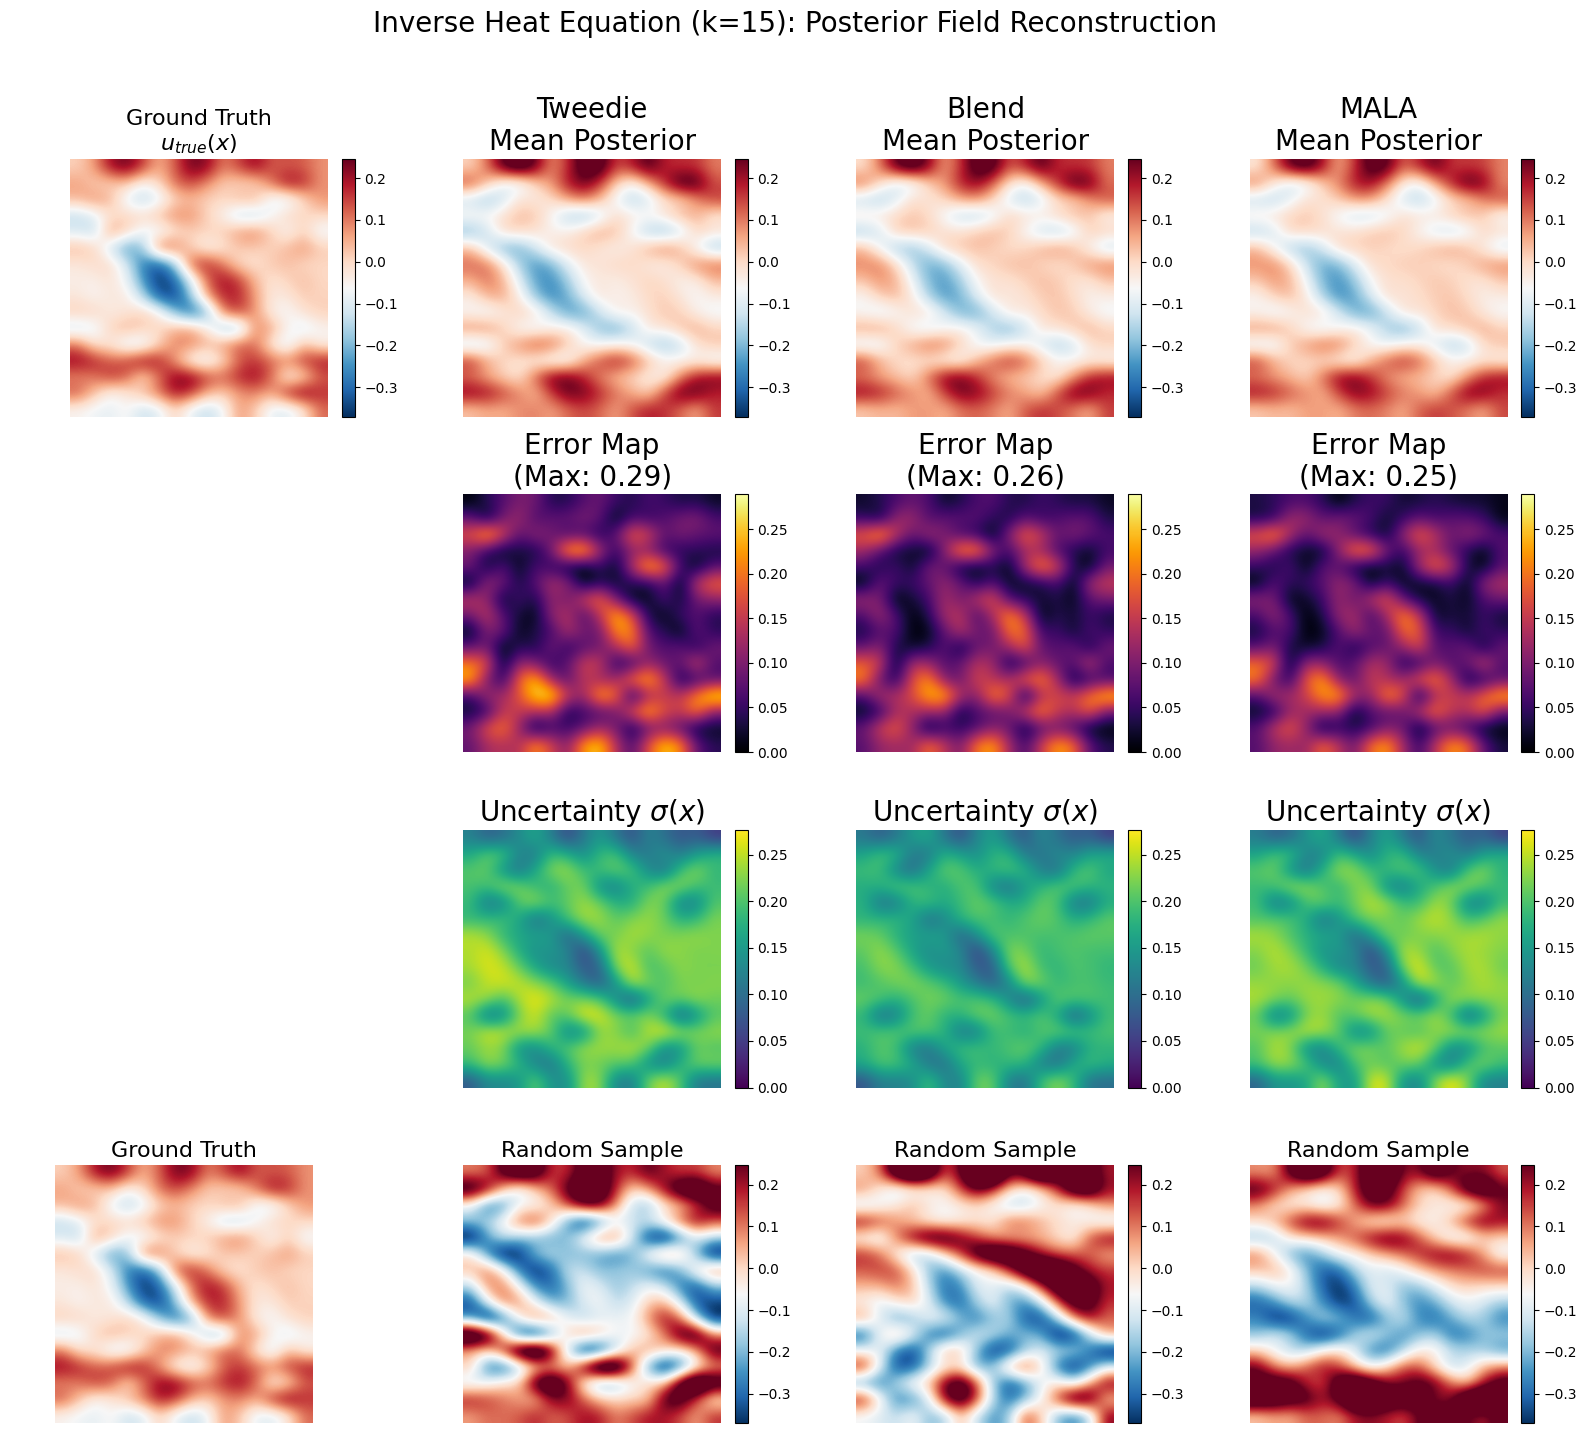


=== Physical Parameter Space Metrics ===
Method               | Inverse Rel. L2 Error (%)      | Forward Rel. Error  
--------------------------------------------------------------------------------
tweedie              | 101.4452                       | 0.029146            
blend_posterior      | 93.8659                        | 0.030340            
mala                 | 90.6047                        | 0.028061            

=== Ambient/physics metrics (conductivity + forward error) ===
Method               | RMSE_field   | RelL2_field  | FwdRelErr   
-----------------------------------------------------------------
tweedie              | 1.1819e-01   | 1.0145       | 2.9146e-02  
blend_posterior      | 1.0936e-01   | 0.9387       | 3.0340e-02  
mala                 | 1.0556e-01   | 0.9060       | 2.8061e-02  

=== Final HEAT metrics (paper-ready) ===
Method               | RMSE_a    | RMSE_u    | FwdRel    | MMD       | KSD       | KLdiag   
----------------------------------------

In [ ]:
# Cell 7: Scientific Visualization & Physics Metrics
# This cell assumes 'samples_heat', 'alpha_true_np', 'Eigen', 'Sigma' are available from previous cells.

import matplotlib.pyplot as plt
import numpy as np
import torch

# ==========================================
# 1. PHYSICS RECONSTRUCTION HELPERS
# ==========================================
# Access global physics matrices from Cell 1
# Convert JAX/Torch arrays to Numpy for visualization
try:
    Eigen_np = np.array(Eigen) # (256, 15)
    Sigma_np = np.array(Sigma) # (15, 15)
except NameError:
    print("Warning: Physics matrices 'Eigen'/'Sigma' not found in scope. Ensure Cell 1 is run.")

def reconstruct_field(latents_k_dim):
    """
    Maps latent samples (dim=ACTIVE_DIM) to physical conductivity fields u(x).
    Pipeline: alpha_k -> pad to 15 -> unwhiten (Sigma) -> basis expansion (Eigen).
    """
    # Ensure input is numpy
    if isinstance(latents_k_dim, torch.Tensor):
        latents_k_dim = latents_k_dim.cpu().numpy()

    # Handle single sample case
    if latents_k_dim.ndim == 1:
        latents_k_dim = latents_k_dim[np.newaxis, :]

    N, k = latents_k_dim.shape

    # 1. Pad to FULL_DIM (15)
    # We use the global FULL_DIM set in previous cells (usually 15)
    full_dim = Sigma_np.shape[0]
    padding = np.zeros((N, full_dim - k))
    latents_full = np.hstack([latents_k_dim, padding]) # [N, 15]

    # 2. Map to Physical Space (Linear Transform)
    # u = x @ (Eigen @ Sigma).T
    # Cell 1 logic: parameter = dot(x, transpose(dot(Eigen, Sigma)))
    transform_matrix = np.dot(Eigen_np, Sigma_np) # [256, 15]

    # [N, 15] @ [15, 256] -> [N, 256]
    fields_flat = np.dot(latents_full, transform_matrix.T)

    # 3. Reshape to 2D Grid
    # Domain is square, so sqrt(256) = 16
    grid_size = int(np.sqrt(fields_flat.shape[1]))
    fields_2d = fields_flat.reshape(N, grid_size, grid_size)

    return fields_2d

# Local clean samples helper to ensure robustness without external dependencies
def get_valid_samples(samps_torch):
    samps = samps_torch.cpu().numpy()
    # Filter NaNs
    valid = samps[np.isfinite(samps).all(axis=1)]
    if len(valid) < 10: return valid

    # Filter IQRs (Robust)
    q25 = np.percentile(valid, 25, axis=0)
    q75 = np.percentile(valid, 75, axis=0)
    iqr = q75 - q25
    mask = ((valid >= q25 - 5*iqr) & (valid <= q75 + 5*iqr)).all(axis=1)
    return valid[mask]

# ==========================================
# 2. QUANTITATIVE METRICS (Physical Space)
# ==========================================
print("\n=== Physical Parameter Space Metrics ===")
print(f"{'Method':<20} | {'Inverse Rel. L2 Error (%)':<30} | {'Forward Rel. Error':<20}")
print("-" * 80)

# Reconstruct Ground Truth Field
true_field = reconstruct_field(alpha_true_np)[0]
norm_true = np.linalg.norm(true_field) + 1e-9

# Recompute noiseless observation for forward error reference
# If JAX function available from previous cell
try:
    y_clean_ref = np.array(heat_forward_Nd(alpha_true_np))
    norm_y_clean = np.linalg.norm(y_clean_ref) + 1e-9
except:
    y_clean_ref = None

# Store mean fields for plotting
mean_fields = {}

# Evaluate each method
for m, samps in samples_heat.items():
    # Use robust cleaning to ignore MCMC outliers
    samps_clean = get_valid_samples(samps)

    if len(samps_clean) < 10:
        print(f"{m:<20} | FAILED (Unstable)")
        continue

    # 1. Compute Posterior Mean in Latent Space
    # Note: Because the map is linear, Mean(Field) = Field(Mean(Latent))
    mean_latent = np.mean(samps_clean, axis=0)

    # 2. Reconstruct Mean Field
    mean_field_rec = reconstruct_field(mean_latent)[0]
    mean_fields[m] = mean_field_rec

    # 3. Compute Relative L2 Error (Inverse)
    l2_error = np.linalg.norm(mean_field_rec - true_field)
    rel_error_pct = (l2_error / norm_true) * 100

    # 4. Compute Forward Error
    if y_clean_ref is not None:
        # Map mean latent -> Y
        try:
            y_pred = np.array(heat_forward_Nd(mean_latent))
            fwd_err = np.linalg.norm(y_pred - y_clean_ref) / norm_y_clean
            fwd_str = f"{fwd_err:.6f}"
        except:
            fwd_str = "N/A"
    else:
        fwd_str = "N/A"

    print(f"{m:<20} | {rel_error_pct:<30.4f} | {fwd_str:<20}")

# ==========================================
# 3. QUALITATIVE VISUALIZATION (Paper Style)
# ==========================================
print("\nVisualizing Individual Conductivity Fields and Error Maps...")

methods_to_plot = ['tweedie', 'blend_posterior', 'mala']
titles = {'mala': 'MALA', 'tweedie': 'Tweedie', 'blend_posterior': 'Blend'}


# Filter to methods that actually ran
methods_to_plot = [m for m in methods_to_plot if m in samples_heat]

n_cols = len(methods_to_plot) + 1 # +1 for Truth column
fig, axes = plt.subplots(4, n_cols, figsize=(4 * n_cols, 14))

# Define plot titles
row_titles = ["Mean Posterior", "Error Map $|\\bar{u} - u_{true}|$", "Uncertainty (Std Dev)", "Random Posterior Sample"]

# --- Column 0: Ground Truth ---
vmin, vmax = true_field.min(), true_field.max()
# Added interpolation='bicubic' for smooth field visualization
im0 = axes[0, 0].imshow(true_field, cmap='RdBu_r', origin='lower', vmin=vmin, vmax=vmax, interpolation='bicubic')
axes[0, 0].set_title("Ground Truth\n$u_{true}(x)$", fontsize=16)
axes[0, 0].axis('off')
plt.colorbar(im0, ax=axes[0, 0], fraction=0.046, pad=0.04)

# Plot Truth again in bottom row for reference
axes[3, 0].imshow(true_field, cmap='RdBu_r', origin='lower', vmin=vmin, vmax=vmax, interpolation='bicubic')
axes[3, 0].set_title("Ground Truth", fontsize=16)
axes[3, 0].axis('off')

# Turn off unused slots in Truth column
axes[1, 0].axis('off')
axes[2, 0].axis('off')

# --- Columns 1..N: Methods ---
# Pre-calculate max error and std for shared colorbars
max_err = 0
max_std = 0
for m in methods_to_plot:
    if m in mean_fields:
        err = np.abs(mean_fields[m] - true_field)
        max_err = max(max_err, err.max())

        samps = get_valid_samples(samples_heat[m])
        if len(samps) > 500: samps = samps[:500]
        fields = reconstruct_field(samps)
        max_std = max(max_std, np.std(fields, axis=0).max())

for i, m in enumerate(methods_to_plot):
    col = i + 1

    # Data Prep
    mean_f = mean_fields[m]
    samps_clean = get_valid_samples(samples_heat[m])

    # 1. Mean Posterior Field
    im_mean = axes[0, col].imshow(mean_f, cmap='RdBu_r', origin='lower', vmin=vmin, vmax=vmax, interpolation='bicubic')
    axes[0, col].set_title(f"{titles[m]}\nMean Posterior", fontsize=20)
    axes[0, col].axis('off')
    plt.colorbar(im_mean, ax=axes[0, col], fraction=0.046, pad=0.04)

    # 2. Absolute Error Map (|Mean - True|)
    err_f = np.abs(mean_f - true_field)  # <--- This line was missing
    im_err = axes[1, col].imshow(err_f, cmap='inferno', origin='lower', vmin=0, vmax=max_err, interpolation='bicubic')
    axes[1, col].set_title(f"Error Map\n(Max: {err_f.max():.2f})", fontsize=20)
    axes[1, col].axis('off')
    plt.colorbar(im_err, ax=axes[1, col], fraction=0.046, pad=0.04)

    # 3. Uncertainty (Std Dev) Map
    # Subsample if too large to save memory
    if len(samps_clean) > 1000: samps_clean = samps_clean[:1000]

    batch_fields = reconstruct_field(samps_clean) # [N_subs, 16, 16]
    std_f = np.std(batch_fields, axis=0)

    im_std = axes[2, col].imshow(std_f, cmap='viridis', origin='lower', vmin=0, vmax=max_std, interpolation='bicubic')
    axes[2, col].set_title(f"Uncertainty $\sigma(x)$", fontsize=20)
    axes[2, col].axis('off')
    plt.colorbar(im_std, ax=axes[2, col], fraction=0.046, pad=0.04)

    #4. Random Individual Sample
    if len(batch_fields) > 0:
        sample_f = batch_fields[-1]
        im_samp = axes[3, col].imshow(sample_f, cmap='RdBu_r', origin='lower', vmin=vmin, vmax=vmax, interpolation='bicubic')
        axes[3, col].set_title(f"Random Sample", fontsize=16)
        axes[3, col].axis('off')
        plt.colorbar(im_samp, ax=axes[3, col], fraction=0.046, pad=0.04)

plt.suptitle(f"Inverse Heat Equation (k={ACTIVE_DIM}): Posterior Field Reconstruction", fontsize=20, y=1.02)
plt.tight_layout()
plt.show()


# ==========================================
# 2. QUANTITATIVE METRICS (Physical Space)
# ==========================================
print("\n=== Physical Parameter Space Metrics ===")
print(f"{'Method':<20} | {'Inverse Rel. L2 Error (%)':<30} | {'Forward Rel. Error':<20}")
print("-" * 80)

# Reconstruct Ground Truth Field
true_field = reconstruct_field(alpha_true_np)[0]
norm_true = np.linalg.norm(true_field) + 1e-12

# Noiseless observation reference for forward-error
y_clean_ref = None
norm_y_clean = None
try:
    y_clean_ref = np.array(heat_forward_Nd(alpha_true_np))
    norm_y_clean = np.linalg.norm(y_clean_ref) + 1e-12
except Exception:
    pass

# Store mean fields for plotting
mean_fields = {}

# RMSE helper (ambient/field space)
def rmse_array(a_hat, a_true):
    return float(np.sqrt(np.mean((a_hat - a_true) ** 2)))

# ---- Physical metrics table (use metrics_heat mean_latent if available) ----
for m, samps in samples_heat.items():
    samps_clean = get_valid_samples(samps)

    if len(samps_clean) < 10:
        print(f"{m:<20} | FAILED (Unstable)")
        continue

    # Prefer mean_latent from metrics_heat (computed in your metrics cell), to stay consistent.
    if ("metrics_heat" in globals()) and (m in metrics_heat) and ("mean_latent" in metrics_heat[m]):
        mean_latent = np.array(metrics_heat[m]["mean_latent"])
    else:
        mean_latent = np.mean(samps_clean, axis=0)

    # Mean field recon (linearity: Field(E[alpha]) = E[Field(alpha)])
    mean_field_rec = reconstruct_field(mean_latent)[0]
    mean_fields[m] = mean_field_rec

    # Inverse error (field space)
    rel_error_pct = (np.linalg.norm(mean_field_rec - true_field) / norm_true) * 100.0

    # Forward error (observation space)
    if y_clean_ref is not None:
        try:
            y_pred = np.array(heat_forward_Nd(mean_latent))
            fwd_err = np.linalg.norm(y_pred - y_clean_ref) / norm_y_clean
            fwd_str = f"{float(fwd_err):.6f}"
        except Exception:
            fwd_str = "Err"
    else:
        fwd_str = "N/A"

    print(f"{m:<20} | {rel_error_pct:<30.4f} | {fwd_str:<20}")

# ---- Ambient/physics metrics + final paper-ready summary (MATCH NS STYLE) ----
if "metrics_heat" in globals():
    print("\n=== Ambient/physics metrics (conductivity + forward error) ===")
    print(f"{'Method':<20} | {'RMSE_field':<12} | {'RelL2_field':<12} | {'FwdRelErr':<12}")
    print("-" * 65)

    for m in list(metrics_heat.keys()):
        if "mean_latent" not in metrics_heat[m]:
            continue

        mean_latent = np.array(metrics_heat[m]["mean_latent"])
        mean_field_rec = reconstruct_field(mean_latent)[0]

        rmse_field = rmse_array(mean_field_rec, true_field)
        rel_field  = float(np.linalg.norm(mean_field_rec - true_field) / norm_true)

        # forward relative error (same mean_latent)
        if y_clean_ref is not None:
            try:
                y_pred = np.array(heat_forward_Nd(mean_latent))
                fwd_rel = float(np.linalg.norm(y_pred - y_clean_ref) / norm_y_clean)
            except Exception:
                fwd_rel = float("nan")
        else:
            fwd_rel = float("nan")

        metrics_heat[m].update(dict(
            RMSE_field=rmse_field,
            RelL2_field=rel_field,
            FwdRelErr=fwd_rel,
        ))

        print(f"{m:<20} | {rmse_field:<12.4e} | {rel_field:<12.4f} | {fwd_rel:<12.4e}")

    print("\n=== Final HEAT metrics (paper-ready) ===")
    print(f"{'Method':<20} | {'RMSE_a':<9} | {'RMSE_u':<9} | {'FwdRel':<9} | {'MMD':<9} | {'KSD':<9} | {'KLdiag':<9}")
    print("-" * 90)

    for m, d in metrics_heat.items():
        rmse_a  = d.get("RMSE_alpha", float("nan"))
        rmse_u  = d.get("RMSE_field", float("nan"))
        fwd_rel = d.get("FwdRelErr", float("nan"))
        mmd     = d.get("MMD_to_MALA", float("nan"))
        ksd     = d.get("KSD", float("nan"))
        kl      = d.get("KLdiag", float("nan"))

        print(f"{m:<20} | {rmse_a:<9.3e} | {rmse_u:<9.3e} | {fwd_rel:<9.3e} | "
              f"{mmd:<9.3e} | {ksd:<9.3e} | {kl:<9.3e}")
else:
    print("\n(Note) 'metrics_heat' not found; run the previous metrics cell first to enable the paper-ready summary.")

In [ ]:
'''import torch
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import time
import math
import os
import pandas as pd
from scipy import sparse
from functools import partial
import gc

# ==========================================
# CONFIGURATION
# ==========================================
# JAX uses float64 for the PDE solver. PyTorch must match it.
jax.config.update("jax_enable_x64", True)
torch.set_default_dtype(torch.float64)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Global Dtype set to: {torch.get_default_dtype()}")
print(f"Device: {device}")

# Configuration
FULL_DIM = 15
ACTIVE_DIM = 15
NOISE_STD = .048

# ==========================================
# 1. BRIDGE: JAX PHYSICS -> PYTORCH SAMPLER
# ==========================================

print("Initializing JAX Physics Engine (Heat Equation)...")

# --- DATA LOADING (PRESERVED FROM USER CONTEXT) ---
n = 15
dimension_of_PoI = (n + 1)**2
num_observation = 10
num_truncated_series = 15

try:
    df_Eigen = pd.read_csv('data/prior_mean_n15_AC_1_1_pt5.csv')
    df_Sigma = pd.read_csv('data/prior_covariance_n15_AC_1_1_pt5.csv')
    Eigen = np.reshape(df_Eigen.to_numpy(), (dimension_of_PoI, num_truncated_series))
    Sigma = np.reshape(df_Sigma.to_numpy(), (num_truncated_series, num_truncated_series))
except FileNotFoundError:
    # Create dummies for testing if files missing (prevents crash if user doesn't have data locally)
    print("WARNING: Data files not found. Creating Dummy Data for Compilation Check.")
    Eigen = np.random.randn(dimension_of_PoI, num_truncated_series)
    Sigma = np.eye(num_truncated_series)

# Observation Indices
obs_file = 'data/heat_obs_indices.csv'
try:
    df_obs = pd.read_csv(obs_file)
    obs_indices = np.reshape(df_obs.to_numpy(), (num_observation, -1))
except FileNotFoundError:
    print(f"Warning: '{obs_file}' not found. Creating random indices...")
    df_free_temp = pd.read_csv('data/prior_covariance_cholesky_n15_AC_1_1_pt5.csv')
    all_free = df_free_temp.to_numpy().flatten()
    random_indices = np.random.choice(all_free, size=num_observation, replace=False)
    obs_indices = np.reshape(random_indices, (num_observation, -1))

# Free Indices
try:
    df_free_index = pd.read_csv('data/prior_covariance_cholesky_n15_AC_1_1_pt5.csv')
    free_index = df_free_index.to_numpy()
except:
    free_index = np.arange(dimension_of_PoI).reshape(-1, 1) # Fallback

# Obs Matrix Construction
i = 0
obs_transfered = []
obs_flat = set(obs_indices.flatten())
for free_ind in free_index:
    if free_ind[0] in obs_flat:
        obs_transfered.append(i)
    i += 1

obs_operator = np.zeros((num_observation, free_index.shape[0]))
for j, obs_idx_reduced in enumerate(obs_transfered):
    obs_operator[j, obs_idx_reduced] = 1

# Load Finite Element Matrices
try:
    pre_mat_stiff_sparse = sparse.load_npz('data/prestiffness_n15.npz')
    load_vector_n15 = sparse.load_npz('data/load_vector_n15.npz')
    load_vector = sparse.csr_matrix.todense(load_vector_n15).T
except:
    # Dummy fallback
    pre_mat_stiff_sparse = sparse.eye(dimension_of_PoI**2)
    load_vector = np.ones((dimension_of_PoI, 1))

# Convert to JAX arrays
obs_operator = jax.numpy.asarray(obs_operator)
Eigen = jax.numpy.asarray(Eigen)
Sigma = jax.numpy.asarray(Sigma)
load_vector = jax.numpy.asarray(load_vector)

# Pre-process Sparse Matrix
values = np.asarray([[pre_mat_stiff_sparse[i,j]] for i, j in zip(*pre_mat_stiff_sparse.nonzero())]).squeeze()
rows, cols = pre_mat_stiff_sparse.nonzero()

# --- JAX FUNCTIONS (PRESERVED) ---
@partial(jax.jit, static_argnums=(4))
def sp_matmul(values, rows, cols, B, shape):
    B = jnp.expand_dims(B, axis = 1)
    in_ = B.take(cols, axis=0)
    prod = in_*values[:, None]
    res = jax.ops.segment_sum(prod, rows, shape)
    return res

def solve_forward(x):
    parameter_of_interest = jnp.dot(x, jnp.transpose(jnp.dot(Eigen, Sigma)))
    stiff = sp_matmul(values, rows, cols, jnp.exp(parameter_of_interest), dimension_of_PoI**2)
    stiff = jnp.reshape(stiff, (dimension_of_PoI, dimension_of_PoI))
    A = jnp.squeeze(jnp.take(stiff, free_index, axis=1))
    B = jnp.squeeze(jnp.take(A, free_index, axis=0))
    state = jnp.linalg.solve(B, load_vector)
    out_pred = jnp.dot(obs_operator, state).squeeze()
    return out_pred

@jax.jit
def pad_coefficients(alpha_k):
    padding = jnp.zeros(FULL_DIM - ACTIVE_DIM)
    return jnp.concatenate([alpha_k, padding])

@jax.jit
def heat_forward_Nd(alpha_k):
    alpha_full = pad_coefficients(alpha_k)
    return solve_forward(alpha_full)

@jax.jit
def heat_log_likelihood_jax(alpha_k, y_obs_jax, sigma):
    y_pred = heat_forward_Nd(alpha_k)
    resid = y_pred - y_obs_jax
    return -jnp.sum(resid**2) / (2 * sigma**2)

heat_grad_lik_jax = jax.jit(jax.grad(heat_log_likelihood_jax, argnums=0))
batch_log_lik = jax.vmap(heat_log_likelihood_jax, in_axes=(0, None, None))
batch_grad_lik = jax.vmap(heat_grad_lik_jax, in_axes=(0, None, None))

# --- PYTORCH INTERFACE ---
class HeatEquationLikelihood:
    def __init__(self, y_obs_np, sigma):
        self.y_obs_jax = jnp.array(y_obs_np)
        self.sigma = sigma

    def log_likelihood(self, x_torch):
        x_np = x_torch.detach().cpu().numpy()
        ll_jax = batch_log_lik(x_np, self.y_obs_jax, self.sigma)
        return torch.tensor(np.array(ll_jax), device=x_torch.device, dtype=torch.float64)

    def grad_log_likelihood(self, x_torch):
        x_np = x_torch.detach().cpu().numpy()
        grad_jax = batch_grad_lik(x_np, self.y_obs_jax, self.sigma)
        return torch.tensor(np.array(grad_jax), device=x_torch.device, dtype=torch.float64)

# ==========================================
# 2. PRIOR
# ==========================================
class GaussianPrior(torch.nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def sample(self, n):
        return torch.randn(n, self.dim, device=device)

    def log_prob(self, x):
        return -0.5 * torch.sum(x**2, dim=1) - (self.dim/2.0) * math.log(2*math.pi)

    def score0(self, x):
        return -x

# ==========================================
# 3. BATCHED SCORE COMPUTATION (NEW)
# ==========================================

def eval_score_batched(y, t, X_ref_cpu, s0_ref_cpu, log_lik_ref_cpu, batch_size=4096, mode='blend_posterior'):
    """
    Computes Tweedie or Blend Posterior score using streaming batches to avoid OOM.
    Reference data (X_ref_cpu, etc.) stays on CPU.
    """
    t_val = t.item() if isinstance(t, torch.Tensor) else t
    if t_val < 1e-4: t_val = 1e-4

    et = math.exp(-t_val)
    var_t = 1.0 - math.exp(-2 * t_val)
    inv_v = 1.0 / var_t

    # Constants for Blend
    scale_factor = 1.0 / et

    M_query = y.shape[0]
    N_ref = X_ref_cpu.shape[0]

    # --- PASS 1: Find Global Max Log-Weight (Stability) ---
    max_log_w = torch.full((M_query,), -float('inf'), device=y.device)

    for i in range(0, N_ref, batch_size):
        # Move chunk to GPU
        X_batch = X_ref_cpu[i:i+batch_size].to(y.device)
        ll_batch = log_lik_ref_cpu[i:i+batch_size].to(y.device)

        # log_weight = -||y - exp(-t)x||^2 / 2var + log_lik
        mus = et * X_batch
        dists_sq = torch.sum((y.unsqueeze(1) - mus.unsqueeze(0))**2, dim=2)
        log_w_batch = -dists_sq / (2 * var_t) + ll_batch.unsqueeze(0)

        # Update running max
        current_max, _ = torch.max(log_w_batch, dim=1)
        max_log_w = torch.max(max_log_w, current_max)

    # --- PASS 2: Accumulate Moments ---
    # Common Accumulators
    denom_Z = torch.zeros((M_query, 1), device=y.device) # sum(w_tilde)
    numer_mu_x = torch.zeros_like(y)                     # sum(w_tilde * x)

    # Blend Accumulators (Sum of w_tilde^2 * term)
    if mode == 'blend_posterior':
        numer_s0 = torch.zeros_like(y)                   # sum(w_tilde * s0)
        acc_w2 = torch.zeros((M_query, 1), device=y.device)
        acc_w2_s0_norm = torch.zeros((M_query,), device=y.device)
        acc_w2_s0 = torch.zeros_like(y)
        acc_w2_x = torch.zeros_like(y)
        acc_w2_x_norm = torch.zeros((M_query,), device=y.device)
        acc_w2_dot = torch.zeros((M_query,), device=y.device) # sum(w_tilde^2 * (s0 . x))

    for i in range(0, N_ref, batch_size):
        X_batch = X_ref_cpu[i:i+batch_size].to(y.device)
        ll_batch = log_lik_ref_cpu[i:i+batch_size].to(y.device)

        mus = et * X_batch
        dists_sq = torch.sum((y.unsqueeze(1) - mus.unsqueeze(0))**2, dim=2)
        log_w = -dists_sq / (2 * var_t) + ll_batch.unsqueeze(0)

        # Stable Unnormalized Weights: w_tilde = exp(log_w - M)
        w_batch = torch.exp(log_w - max_log_w.unsqueeze(1))

        # 1st Moment Accumulation
        denom_Z += torch.sum(w_batch, dim=1, keepdim=True)
        numer_mu_x += torch.einsum('mb,bd->md', w_batch, X_batch)

        if mode == 'blend_posterior':
            s0_batch = s0_ref_cpu[i:i+batch_size].to(y.device)
            numer_s0 += torch.einsum('mb,bd->md', w_batch, s0_batch)

            # 2nd Moment Accumulation (Squared Weights)
            w2_batch = w_batch**2
            acc_w2 += torch.sum(w2_batch, dim=1, keepdim=True)

            # Precompute batch norms/dots
            s0_sq_batch = torch.sum(s0_batch**2, dim=1)
            x_sq_batch = torch.sum(X_batch**2, dim=1)
            dot_batch = torch.sum(s0_batch * X_batch, dim=1)

            acc_w2_s0_norm += torch.mv(w2_batch, s0_sq_batch)
            acc_w2_s0 += torch.mm(w2_batch, s0_batch)
            acc_w2_x += torch.mm(w2_batch, X_batch)
            acc_w2_x_norm += torch.mv(w2_batch, x_sq_batch)
            acc_w2_dot += torch.mv(w2_batch, dot_batch)

    # --- FINALIZE / RECONSTRUCTION ---
    eps = 1e-12
    # Tweedie Score: -(y - et * E[x])/var_t
    mu_x = numer_mu_x / denom_Z
    score_twd = -inv_v * (y - et * mu_x)

    if mode == 'tweedie':
        return score_twd

    # Blend Logic Reconstruction
    # Key Identity: sum(w_norm^2 * term) = (1/Z^2) * sum(w_tilde^2 * term)
    Z_sq = denom_Z**2

    # 1. Reconstruct Expectations
    mu_a = scale_factor * (numer_s0 / denom_Z)
    mu_b = score_twd # Tweedie is mu_b

    S0 = acc_w2 / Z_sq

    # S1a = sum(w^2 ||a||^2) -> a = scale * s0 -> scale^2 * sum(w^2 ||s0||^2)
    S1a = (scale_factor**2) * (acc_w2_s0_norm.unsqueeze(1) / Z_sq)

    # S2a = sum(w^2 a) -> scale * sum(w^2 s0)
    S2a = scale_factor * (acc_w2_s0 / Z_sq)

    # Vk calculation
    den_sn = torch.clamp(1.0 - S0, min=eps)
    mu_a_norm2 = torch.sum(mu_a**2, dim=1, keepdim=True)
    num_Vk = S1a - 2.0 * torch.sum(mu_a * S2a, dim=1, keepdim=True) + mu_a_norm2 * S0
    Vk = num_Vk / den_sn

    # Vt Calculation
    # Need S1b, S2b
    # S2b = -inv_v * (y * S0 - et * sum(w^2 x))
    term_w2_x = acc_w2_x / Z_sq
    S2b = -inv_v * (y * S0 - et * term_w2_x)

    # S1b logic from original:
    # y_norm2 * S0 - 2*et*sum(w^2 y.x) + et^2 sum(w^2 ||x||^2)
    # y is constant per query, pull out
    y_norm2 = torch.sum(y**2, dim=1, keepdim=True)
    y_dot_w2x = torch.sum(y * term_w2_x, dim=1, keepdim=True)
    term_w2_x_norm = acc_w2_x_norm.unsqueeze(1) / Z_sq

    S1b = (inv_v**2) * (y_norm2 * S0 - 2.0 * et * y_dot_w2x + (et**2) * term_w2_x_norm)

    mu_b_norm2 = torch.sum(mu_b**2, dim=1, keepdim=True)
    num_Vt = S1b - 2.0 * torch.sum(mu_b * S2b, dim=1, keepdim=True) + mu_b_norm2 * S0
    Vt = num_Vt / den_sn

    # Covariance C Calculation
    # a dot z term -> scale * sum(w^2 s0.x)
    term_w2_dot = acc_w2_dot.unsqueeze(1) / Z_sq
    term_c2 = scale_factor * term_w2_dot

    # term_c1 = sum(S2a * y) -> dot product per row
    term_c1 = torch.sum(S2a * y, dim=1, keepdim=True)

    Sab = -inv_v * (term_c1 - et * term_c2)

    num_C = Sab - torch.sum(mu_a * S2b, dim=1, keepdim=True) - torch.sum(mu_b * S2a, dim=1, keepdim=True) + torch.sum(mu_a * mu_b, dim=1, keepdim=True) * S0
    C = num_C / den_sn

    # Lambda and Combination
    denom = torch.clamp(Vk + Vt - 2.0 * C, min=eps)
    lam = (Vk - C) / denom
    lam = torch.clamp(lam, 0.0, 0.95)

    return lam * score_twd + (1.0 - lam) * mu_a # mu_a is s_kss

def get_score_wrapper(y, t, mode, X_ref_cpu, s0_ref_cpu, log_lik_ref_cpu):
    # Call the batched version directly
    # Note: Inputs X_ref, s0_ref, log_lik_ref MUST be CPU tensors now
    score = eval_score_batched(y, t, X_ref_cpu, s0_ref_cpu, log_lik_ref_cpu, mode=mode)
    return score

# ==========================================
# 4. SAMPLERS
# ==========================================
def run_sampler_heun(n_samples, mode, X_ref, s0_post_ref, log_lik_ref, steps=20, dim=15):
    y = torch.randn(n_samples, dim, device=device)
    ts = torch.logspace(0.4, -3.6, steps + 1, device=device)
    for i in range(steps):
        t_cur = ts[i]
        t_next = ts[i+1]
        dt = t_cur - t_next
        s_cur = get_score_wrapper(y, t_cur, mode, X_ref, s0_post_ref, log_lik_ref)
        d_cur = y + 2 * s_cur
        z = torch.randn_like(y)
        y_hat = y + d_cur * dt + math.sqrt(2 * dt) * z
        s_next = get_score_wrapper(y_hat, t_next, mode, X_ref, s0_post_ref, log_lik_ref)
        d_next = y_hat + 2 * s_next
        drift_avg = 0.5 * (d_cur + d_next)
        y = y + drift_avg * dt + math.sqrt(2 * dt) * z
    return y

def run_sampler_rk4(n_samples, mode, X_ref, s0_post_ref, log_lik_ref, steps=20, dim=15):
    y = torch.randn(n_samples, dim, device=device)
    ts = torch.logspace(0.4, -3.6, steps + 1, device=device)
    for i in range(steps):
        t_cur = ts[i]
        t_next = ts[i+1]
        h = t_next - t_cur
        def get_drift(y_in, t_in):
            score = get_score_wrapper(y_in, t_in, mode, X_ref, s0_post_ref, log_lik_ref)
            return y_in + 2 * score
        k1 = get_drift(y, t_cur)
        k2 = get_drift(y + 0.5 * h * k1, t_cur + 0.5 * h)
        k3 = get_drift(y + 0.5 * h * k2, t_cur + 0.5 * h)
        k4 = get_drift(y + h * k3, t_next)
        y_ode = y + (h / 6.0) * (k1 + 2*k2 + 2*k3 + k4)
        dt_abs = torch.abs(h)
        z = torch.randn_like(y)
        y = y_ode + math.sqrt(2 * dt_abs) * z
    return y

def run_mala_sampler(n_samples, prior_model, lik_model, steps=1000, dt=1e-3, burn_in=200):
    x = prior_model.sample(n_samples)
    log_prior = prior_model.log_prob(x)
    log_lik = lik_model.log_likelihood(x)
    score_prior = prior_model.score0(x)
    grad_lik = lik_model.grad_log_likelihood(x)
    log_post = log_prior + log_lik
    grad_log_post = score_prior + grad_lik
    accept_count = 0
    for i in range(steps):
        noise = torch.randn_like(x)
        x_prop = x + dt * grad_log_post + math.sqrt(2 * dt) * noise
        log_prior_prop = prior_model.log_prob(x_prop)
        log_lik_prop = lik_model.log_likelihood(x_prop)
        score_prior_prop = prior_model.score0(x_prop)
        grad_lik_prop = lik_model.grad_log_likelihood(x_prop)
        log_post_prop = log_prior_prop + log_lik_prop
        grad_log_post_prop = score_prior_prop + grad_lik_prop
        log_q_fwd = -torch.sum((x_prop - x - dt * grad_log_post)**2, dim=1) / (4 * dt)
        log_q_bwd = -torch.sum((x - x_prop - dt * grad_log_post_prop)**2, dim=1) / (4 * dt)
        log_alpha = log_post_prop - log_post + log_q_bwd - log_q_fwd
        accept = torch.log(torch.rand(n_samples, device=device)) < log_alpha
        x[accept] = x_prop[accept]
        log_post[accept] = log_post_prop[accept]
        grad_log_post[accept] = grad_log_post_prop[accept]
        if i >= burn_in:
            accept_count += accept.float().mean().item()
        if i % 100 == 0:
            print(f"MALA Iteration {i}/{steps}")
    print(f"MALA Acceptance: {accept_count / max(1, steps - burn_in):.2f}")
    return x

# ==========================================
# 5. EVALUATION UTILS
# ==========================================
def robust_clean_samples(samps):
    samps_np = samps.cpu().numpy() if isinstance(samps, torch.Tensor) else samps
    valid_mask = np.isfinite(samps_np).all(axis=1)
    if valid_mask.sum() < 10: return torch.tensor(samps_np[valid_mask], device=device)
    q25 = np.percentile(samps_np[valid_mask], 25, axis=0)
    q75 = np.percentile(samps_np[valid_mask], 75, axis=0)
    iqr = q75 - q25
    lower = q25 - 5.0 * iqr
    upper = q75 + 5.0 * iqr
    in_bounds = (samps_np >= lower) & (samps_np <= upper)
    valid_mask = valid_mask & in_bounds.all(axis=1)
    return torch.tensor(samps_np[valid_mask], device=device)

def sliced_wasserstein_distance(X_a, X_b, num_projections=500, p=2):
    n_a = X_a.shape[0]
    n_b = X_b.shape[0]
    if n_a > n_b:
        idx = torch.randperm(n_a)[:n_b]
        X_a = X_a[idx]
    elif n_b > n_a:
        idx = torch.randperm(n_b)[:n_a]
        X_b = X_b[idx]
    dim = X_a.shape[1]
    projections = torch.randn((num_projections, dim), device=X_a.device)
    projections = projections / torch.norm(projections, dim=1, keepdim=True)
    proj_a = torch.matmul(X_a, projections.t())
    proj_b = torch.matmul(X_b, projections.t())
    proj_a_sorted, _ = torch.sort(proj_a, dim=0)
    proj_b_sorted, _ = torch.sort(proj_b, dim=0)
    wd = torch.pow(torch.abs(proj_a_sorted - proj_b_sorted), p).mean()
    return torch.pow(wd, 1.0/p).item()

def compute_moment_errors(samples_approx, samples_ref):
    mean_approx = torch.mean(samples_approx, dim=0)
    mean_ref = torch.mean(samples_ref, dim=0)
    mean_err = torch.norm(mean_approx - mean_ref).item()
    centered_approx = samples_approx - mean_approx
    centered_ref = samples_ref - mean_ref
    cov_approx = torch.matmul(centered_approx.t(), centered_approx) / (samples_approx.shape[0] - 1)
    cov_ref = torch.matmul(centered_ref.t(), centered_ref) / (samples_ref.shape[0] - 1)
    cov_err = torch.norm(cov_approx - cov_ref).item()
    return mean_err, cov_err

def compute_knn_entropy(samples, k=5):
    n, d = samples.shape
    if n <= k: return 0.0
    dists = torch.cdist(samples, samples)
    k_dists, _ = torch.topk(dists, k + 1, largest=False, dim=1)
    r_k = k_dists[:, k]
    log_vd = (d / 2.0) * math.log(math.pi) - torch.lgamma(torch.tensor(d / 2.0 + 1.0, device=samples.device))
    avg_log_dist = torch.log(r_k + 1e-10).mean()
    digamma_k = torch.digamma(torch.tensor(float(k), device=samples.device))
    entropy = d * avg_log_dist + math.log(n) - digamma_k + log_vd
    return entropy.item()

def compute_kl_divergence(samples, prior_model, lik_model):
    clean_x = robust_clean_samples(samples)
    if len(clean_x) < 20: return float('inf')
    entropy = compute_knn_entropy(clean_x, k=5)
    with torch.no_grad():
        log_prior = prior_model.log_prob(clean_x)
        log_lik = lik_model.log_likelihood(clean_x)
        unnorm_log_post = log_prior + log_lik
        expected_log_p = torch.mean(unnorm_log_post).item()
    return -entropy - expected_log_p

def compute_multiscale_ksd(samples, score_func, sigmas=(0.1, 0.2, 0.4, 0.8)):
    N = samples.shape[0]
    if N > 1000:
        idx = torch.randperm(N)[:1000]
        samples = samples[idx]
        N = 1000
    X = samples
    D = X.shape[1]
    s = score_func(X)
    diff = X.unsqueeze(1) - X.unsqueeze(0)
    r2 = torch.sum(diff**2, dim=-1)
    ksd2 = 0.0
    for sigma in sigmas:
        K = torch.exp(-r2 / (2 * sigma**2))
        sdot = torch.matmul(s, s.t())
        term1 = sdot * K
        r_dot_sx = torch.einsum('ijd,id->ij', diff, s)
        r_dot_sy = torch.einsum('ijd,jd->ij', diff, s)
        term2 = (r_dot_sx - r_dot_sy) / (sigma**2) * K
        term3 = (D / (sigma**2) - r2 / (sigma**4)) * K
        U = term1 + term2 + term3
        ksd2 += torch.sum(U) / (N * N)
    return ksd2.item() / len(sigmas)

def posterior_score_fn(x):
    with torch.no_grad():
        s_prior = -x
        s_lik = lik_model_heat.grad_log_likelihood(x)
        return s_prior + s_lik

def compute_mmd_rbf(X, Y, sigma=None):
    n_max = 2000
    if X.shape[0] > n_max: X = X[:n_max]
    if Y.shape[0] > n_max: Y = Y[:n_max]
    dist_xx = torch.cdist(X, X, p=2)**2
    dist_yy = torch.cdist(Y, Y, p=2)**2
    dist_xy = torch.cdist(X, Y, p=2)**2
    if sigma is None:
        combined = torch.cat([dist_xx.view(-1), dist_yy.view(-1), dist_xy.view(-1)])
        sigma = torch.median(combined[combined > 0])
        sigma = torch.sqrt(sigma) if sigma > 0 else 1.0
    gamma = 1.0 / (2 * sigma**2)
    K_xx = torch.exp(-gamma * dist_xx)
    K_yy = torch.exp(-gamma * dist_yy)
    K_xy = torch.exp(-gamma * dist_xy)
    mmd_sq = K_xx.mean() + K_yy.mean() - 2 * K_xy.mean()
    return torch.sqrt(torch.clamp(mmd_sq, min=0.0)).item()

def plot_pca_histograms(samples_dict, alpha_true):
    blend_data = robust_clean_samples(samples_dict['blend_posterior'])
    mean_blend = torch.mean(blend_data, dim=0)
    centered_blend = blend_data - mean_blend
    U, S, V = torch.svd(centered_blend)
    pairs = [(0, 1), (2, 3)]
    methods = ['mala', 'tweedie', 'blend_posterior']
    titles = {'mala': 'MALA', 'tweedie': 'Tweedie', 'blend_posterior': 'Blend'}
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    for row_idx, (d1, d2) in enumerate(pairs):
        if d2 >= V.shape[1]: d1, d2 = 0, 1
        v1, v2 = V[:, d1], V[:, d2]
        true_cent = torch.tensor(alpha_true, device=device) - mean_blend
        t1 = torch.dot(true_cent, v1).item()
        t2 = torch.dot(true_cent, v2).item()
        proj_blend_1 = torch.matmul(centered_blend, v1).cpu().numpy()
        proj_blend_2 = torch.matmul(centered_blend, v2).cpu().numpy()
        q01_x, q99_x = np.percentile(proj_blend_1, [1, 99])
        q01_y, q99_y = np.percentile(proj_blend_2, [1, 99])
        span_x, span_y = q99_x - q01_x, q99_y - q01_y
        pad = 0.5
        xlims = [q01_x - pad*span_x, q99_x + pad*span_x]
        ylims = [q01_y - pad*span_y, q99_y + pad*span_y]
        for col_idx, m in enumerate(methods):
            ax = axes[row_idx, col_idx]
            samps = robust_clean_samples(samples_dict[m])
            centered = samps - mean_blend
            p1 = torch.matmul(centered, v1).cpu().numpy()
            p2 = torch.matmul(centered, v2).cpu().numpy()
            ax.hist2d(p1, p2, bins=60, range=[xlims, ylims], cmap='inferno', density=True, vmax = .2)
            ax.scatter(t1, t2, c='cyan', marker='x', s=200, label='True u')
            if row_idx == 0: ax.set_title(f"{titles[m]}", fontsize=20)
            if col_idx == 0: ax.set_ylabel(f"PC {d1+1} vs PC {d2+1}", fontsize=12)
            if row_idx == 0 and col_idx == 0: ax.legend()
    plt.tight_layout()
    plt.savefig('pca_histograms.png')
    plt.show()

# ==========================================
# 6. EXECUTION
# ==========================================
print(f"--- Setting up {ACTIVE_DIM}D Heat Equation Inverse Problem ---")

# GC Cleanup
gc.collect()
if torch.cuda.is_available(): torch.cuda.empty_cache()
if hasattr(jax, 'clear_caches'): jax.clear_caches()

# 1. Ground Truth
np.random.seed(42)
alpha_true_np = np.random.randn(ACTIVE_DIM) * 0.5
y_clean = heat_forward_Nd(alpha_true_np)
y_obs_np = y_clean + np.random.normal(0, NOISE_STD, size=y_clean.shape)

# 2. Models
prior_model_heat = GaussianPrior(dim=ACTIVE_DIM)
lik_model_heat = HeatEquationLikelihood(y_obs_np, NOISE_STD)

# 3. Precompute
N_REF_HEAT = 28000
print(f"Generating {N_REF_HEAT} Prior Samples...")
t0 = time.time()
X_ref_heat = prior_model_heat.sample(N_REF_HEAT)

with torch.no_grad():
    s0_prior_heat = prior_model_heat.score0(X_ref_heat)
    log_lik_heat = lik_model_heat.log_likelihood(X_ref_heat)
    grad_lik_heat = lik_model_heat.grad_log_likelihood(X_ref_heat)
    s0_post_heat = s0_prior_heat + grad_lik_heat

    # --- KEY MODIFICATION: MOVE REFERENCE TO CPU ---
    print("Moving reference set to CPU to save GPU memory for batching...")
    X_ref_heat = X_ref_heat.cpu()
    s0_post_heat = s0_post_heat.cpu()
    log_lik_heat = log_lik_heat.cpu()

    # Stats
    norm_post = torch.norm(s0_post_heat, dim=1).mean().item()
    avg_ll = log_lik_heat.mean().item()
    print(f"  > Avg Posterior Score Norm:   {norm_post:.4f}")
    print(f"  > Avg Log-Likelihood Value:   {avg_ll:.4f}")

print(f"Precomputation: {time.time()-t0:.2f}s")
gc.collect()
torch.cuda.empty_cache()

# 4. Run Diffusion
N_GEN_HEAT = 1000
samples_heat = {}
modes = ['tweedie', 'blend_posterior']
print(f"Running Diffusion (N={N_GEN_HEAT})...")
for m in modes:
    t_s = time.time()
    # Sampler will now use CPU reference tensors + Batching
    samps = run_sampler_heun(N_GEN_HEAT, m, X_ref_heat, s0_post_heat, log_lik_heat, steps=120, dim=ACTIVE_DIM)
    samples_heat[m] = samps.cpu()
    print(f"{m}: {time.time()-t_s:.2f}s")

# 5. Run MCMC
print("Running MALA (Reference)...")
t_s = time.time()
mcmc_heat = run_mala_sampler(N_GEN_HEAT, prior_model_heat, lik_model_heat, steps=2000, dt=0.001, burn_in=600)
samples_heat['mala'] = mcmc_heat.cpu()
print(f"MALA: {time.time()-t_s:.2f}s")

# ==========================================
# EVALUATION LOOP
# ==========================================
print("\n=== Evaluation (6 Metrics including MMD) ===")
print(f"{'Method':<20} | {'SW2':<10} | {'MMD':<10} | {'Mean Err':<10} | {'Cov Err':<10} | {'KSD':<10} | {'KL':<10}")
print("-" * 95)

ref_clean = robust_clean_samples(samples_heat['mala'])

for m, raw in samples_heat.items():
    samps = robust_clean_samples(raw)
    if samps.shape[0] < 50: continue
    sw2 = sliced_wasserstein_distance(samps, ref_clean)
    mmd = compute_mmd_rbf(samps, ref_clean)
    mean_err, cov_err = compute_moment_errors(samps, ref_clean)
    ksd = compute_multiscale_ksd(samps, posterior_score_fn)
    kl = compute_kl_divergence(samps, prior_model_heat, lik_model_heat)
    print(f"{m:<20} | {sw2:<10.4f} | {mmd:<10.4f} | {mean_err:<10.4f} | {cov_err:<10.4f} | {ksd:<10.4f} | {kl:<10.4f}")

print("\n=== PCA Histograms (3x3) ===")
plot_pca_histograms(samples_heat, alpha_true_np)
'''

<>:203: SyntaxWarning: invalid escape sequence '\s'
<>:203: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-590815228.py:203: SyntaxWarning: invalid escape sequence '\s'
  axes[2, col].set_title(f"Uncertainty $\sigma(x)$", fontsize=20)



=== Physical Parameter Space Metrics ===
Method               | Inverse Rel. L2 Error (%)      | Forward Rel. Error  
--------------------------------------------------------------------------------
tweedie              | 107.3568                       | 0.027317            
blend_posterior      | 99.2392                        | 0.034087            
mala                 | 91.3597                        | 0.026857            

Visualizing Individual Conductivity Fields and Error Maps...


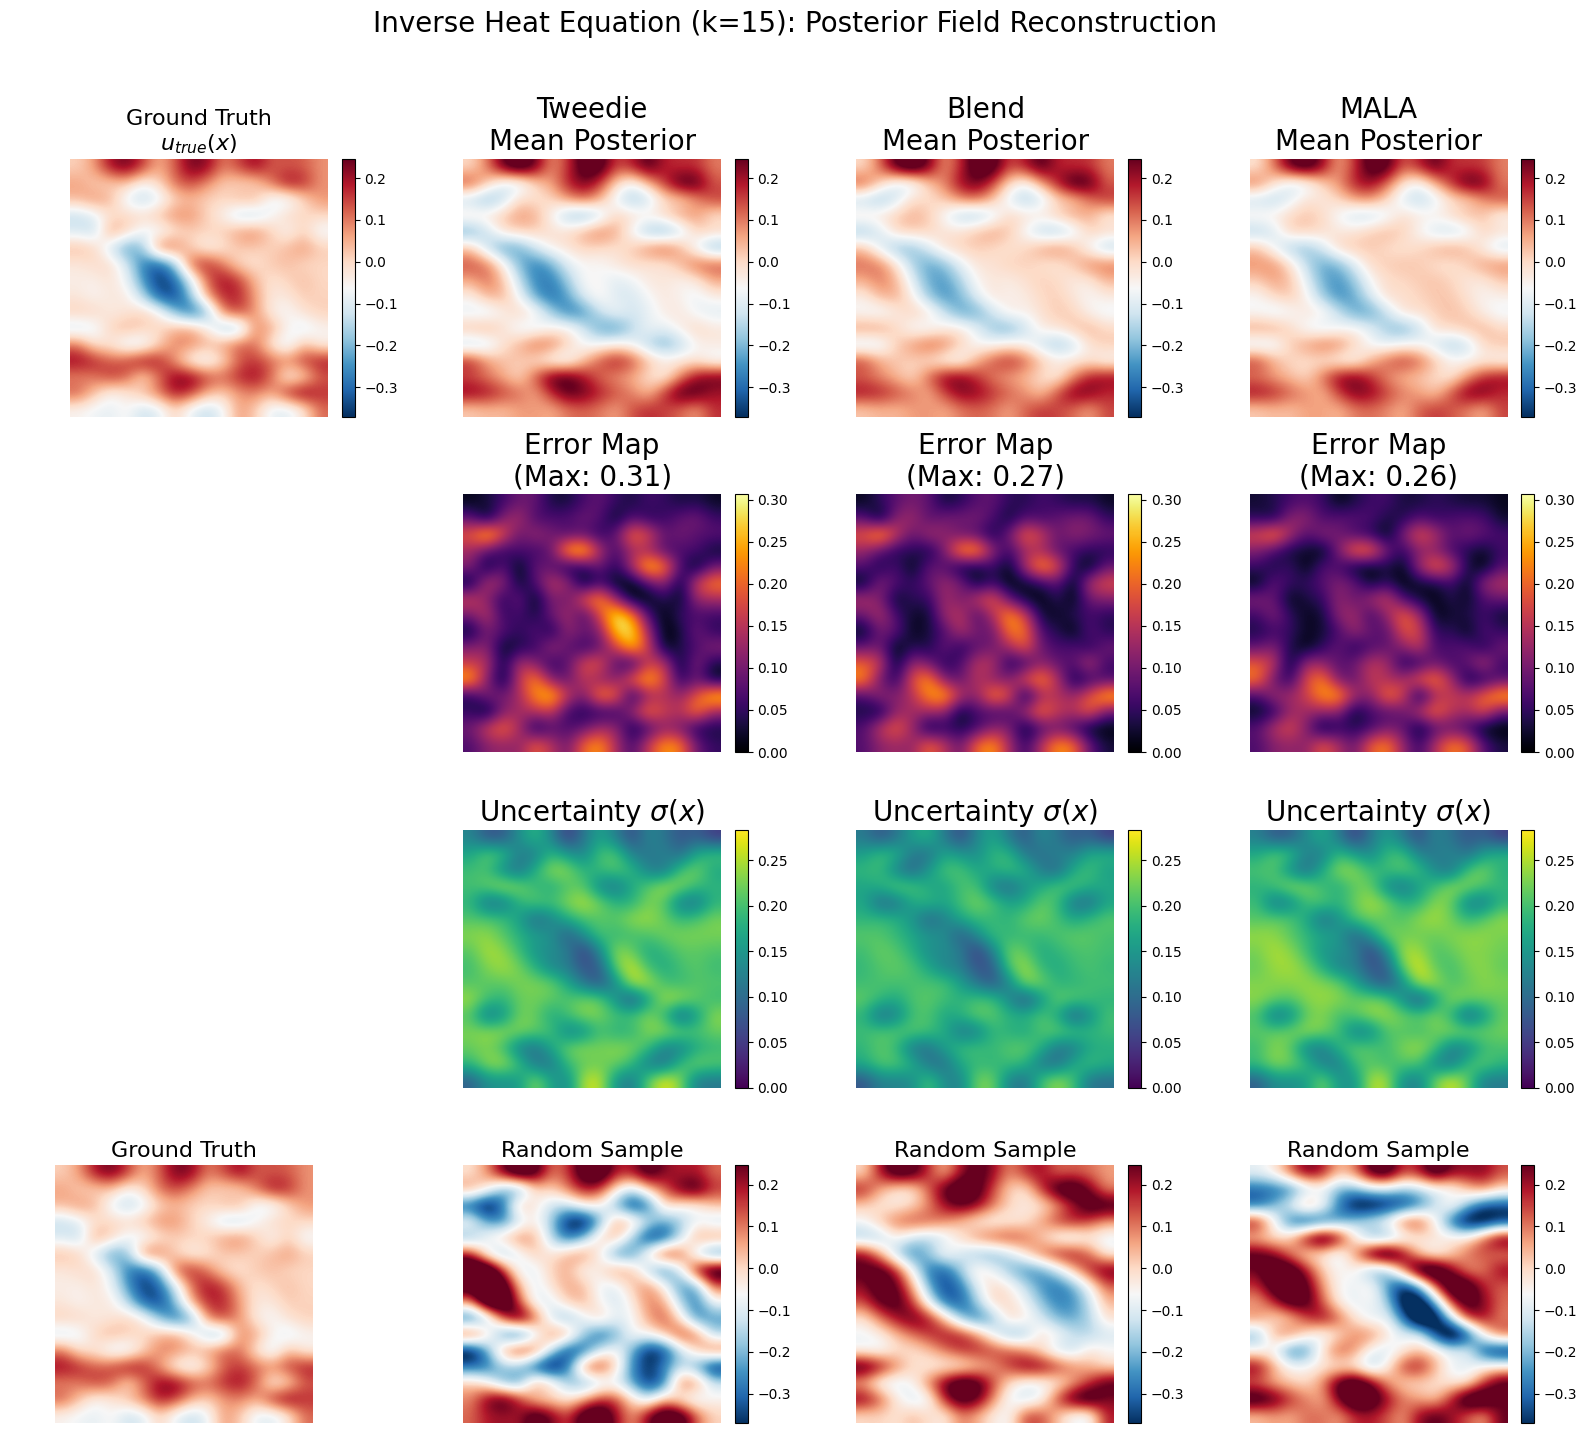

In [ ]:
# Cell 7: Scientific Visualization & Physics Metrics
# This cell assumes 'samples_heat', 'alpha_true_np', 'Eigen', 'Sigma' are available from previous cells.

import matplotlib.pyplot as plt
import numpy as np
import torch

# ==========================================
# 1. PHYSICS RECONSTRUCTION HELPERS
# ==========================================
# Access global physics matrices from Cell 1
# Convert JAX/Torch arrays to Numpy for visualization
try:
    Eigen_np = np.array(Eigen) # (256, 15)
    Sigma_np = np.array(Sigma) # (15, 15)
except NameError:
    print("Warning: Physics matrices 'Eigen'/'Sigma' not found in scope. Ensure Cell 1 is run.")

def reconstruct_field(latents_k_dim):
    """
    Maps latent samples (dim=ACTIVE_DIM) to physical conductivity fields u(x).
    Pipeline: alpha_k -> pad to 15 -> unwhiten (Sigma) -> basis expansion (Eigen).
    """
    # Ensure input is numpy
    if isinstance(latents_k_dim, torch.Tensor):
        latents_k_dim = latents_k_dim.cpu().numpy()

    # Handle single sample case
    if latents_k_dim.ndim == 1:
        latents_k_dim = latents_k_dim[np.newaxis, :]

    N, k = latents_k_dim.shape

    # 1. Pad to FULL_DIM (15)
    # We use the global FULL_DIM set in previous cells (usually 15)
    full_dim = Sigma_np.shape[0]
    padding = np.zeros((N, full_dim - k))
    latents_full = np.hstack([latents_k_dim, padding]) # [N, 15]

    # 2. Map to Physical Space (Linear Transform)
    # u = x @ (Eigen @ Sigma).T
    # Cell 1 logic: parameter = dot(x, transpose(dot(Eigen, Sigma)))
    transform_matrix = np.dot(Eigen_np, Sigma_np) # [256, 15]

    # [N, 15] @ [15, 256] -> [N, 256]
    fields_flat = np.dot(latents_full, transform_matrix.T)

    # 3. Reshape to 2D Grid
    # Domain is square, so sqrt(256) = 16
    grid_size = int(np.sqrt(fields_flat.shape[1]))
    fields_2d = fields_flat.reshape(N, grid_size, grid_size)

    return fields_2d

# Local clean samples helper to ensure robustness without external dependencies
def get_valid_samples(samps_torch):
    samps = samps_torch.cpu().numpy()
    # Filter NaNs
    valid = samps[np.isfinite(samps).all(axis=1)]
    if len(valid) < 10: return valid

    # Filter IQRs (Robust)
    q25 = np.percentile(valid, 25, axis=0)
    q75 = np.percentile(valid, 75, axis=0)
    iqr = q75 - q25
    mask = ((valid >= q25 - 5*iqr) & (valid <= q75 + 5*iqr)).all(axis=1)
    return valid[mask]

# ==========================================
# 2. QUANTITATIVE METRICS (Physical Space)
# ==========================================
print("\n=== Physical Parameter Space Metrics ===")
print(f"{'Method':<20} | {'Inverse Rel. L2 Error (%)':<30} | {'Forward Rel. Error':<20}")
print("-" * 80)

# Reconstruct Ground Truth Field
true_field = reconstruct_field(alpha_true_np)[0]
norm_true = np.linalg.norm(true_field) + 1e-9

# Recompute noiseless observation for forward error reference
# If JAX function available from previous cell
try:
    y_clean_ref = np.array(heat_forward_Nd(alpha_true_np))
    norm_y_clean = np.linalg.norm(y_clean_ref) + 1e-9
except:
    y_clean_ref = None

# Store mean fields for plotting
mean_fields = {}

# Evaluate each method
for m, samps in samples_heat.items():
    # Use robust cleaning to ignore MCMC outliers
    samps_clean = get_valid_samples(samps)

    if len(samps_clean) < 10:
        print(f"{m:<20} | FAILED (Unstable)")
        continue

    # 1. Compute Posterior Mean in Latent Space
    # Note: Because the map is linear, Mean(Field) = Field(Mean(Latent))
    mean_latent = np.mean(samps_clean, axis=0)

    # 2. Reconstruct Mean Field
    mean_field_rec = reconstruct_field(mean_latent)[0]
    mean_fields[m] = mean_field_rec

    # 3. Compute Relative L2 Error (Inverse)
    l2_error = np.linalg.norm(mean_field_rec - true_field)
    rel_error_pct = (l2_error / norm_true) * 100

    # 4. Compute Forward Error
    if y_clean_ref is not None:
        # Map mean latent -> Y
        try:
            y_pred = np.array(heat_forward_Nd(mean_latent))
            fwd_err = np.linalg.norm(y_pred - y_clean_ref) / norm_y_clean
            fwd_str = f"{fwd_err:.6f}"
        except:
            fwd_str = "N/A"
    else:
        fwd_str = "N/A"

    print(f"{m:<20} | {rel_error_pct:<30.4f} | {fwd_str:<20}")

# ==========================================
# 3. QUALITATIVE VISUALIZATION (Paper Style)
# ==========================================
print("\nVisualizing Individual Conductivity Fields and Error Maps...")

methods_to_plot = ['tweedie', 'blend_posterior', 'mala']
titles = {'mala': 'MALA', 'tweedie': 'Tweedie', 'blend_posterior': 'Blend'}


# Filter to methods that actually ran
methods_to_plot = [m for m in methods_to_plot if m in samples_heat]

n_cols = len(methods_to_plot) + 1 # +1 for Truth column
fig, axes = plt.subplots(4, n_cols, figsize=(4 * n_cols, 14))

# Define plot titles
row_titles = ["Mean Posterior", "Error Map $|\\bar{u} - u_{true}|$", "Uncertainty (Std Dev)", "Random Posterior Sample"]

# --- Column 0: Ground Truth ---
vmin, vmax = true_field.min(), true_field.max()
# Added interpolation='bicubic' for smooth field visualization
im0 = axes[0, 0].imshow(true_field, cmap='RdBu_r', origin='lower', vmin=vmin, vmax=vmax, interpolation='bicubic')
axes[0, 0].set_title("Ground Truth\n$u_{true}(x)$", fontsize=16)
axes[0, 0].axis('off')
plt.colorbar(im0, ax=axes[0, 0], fraction=0.046, pad=0.04)

# Plot Truth again in bottom row for reference
axes[3, 0].imshow(true_field, cmap='RdBu_r', origin='lower', vmin=vmin, vmax=vmax, interpolation='bicubic')
axes[3, 0].set_title("Ground Truth", fontsize=16)
axes[3, 0].axis('off')

# Turn off unused slots in Truth column
axes[1, 0].axis('off')
axes[2, 0].axis('off')

# --- Columns 1..N: Methods ---
# Pre-calculate max error and std for shared colorbars
max_err = 0
max_std = 0
for m in methods_to_plot:
    if m in mean_fields:
        err = np.abs(mean_fields[m] - true_field)
        max_err = max(max_err, err.max())

        samps = get_valid_samples(samples_heat[m])
        if len(samps) > 500: samps = samps[:500]
        fields = reconstruct_field(samps)
        max_std = max(max_std, np.std(fields, axis=0).max())

for i, m in enumerate(methods_to_plot):
    col = i + 1

    # Data Prep
    mean_f = mean_fields[m]
    samps_clean = get_valid_samples(samples_heat[m])

    # 1. Mean Posterior Field
    im_mean = axes[0, col].imshow(mean_f, cmap='RdBu_r', origin='lower', vmin=vmin, vmax=vmax, interpolation='bicubic')
    axes[0, col].set_title(f"{titles[m]}\nMean Posterior", fontsize=20)
    axes[0, col].axis('off')
    plt.colorbar(im_mean, ax=axes[0, col], fraction=0.046, pad=0.04)

    # 2. Absolute Error Map (|Mean - True|)
    err_f = np.abs(mean_f - true_field)  # <--- This line was missing
    im_err = axes[1, col].imshow(err_f, cmap='inferno', origin='lower', vmin=0, vmax=max_err, interpolation='bicubic')
    axes[1, col].set_title(f"Error Map\n(Max: {err_f.max():.2f})", fontsize=20)
    axes[1, col].axis('off')
    plt.colorbar(im_err, ax=axes[1, col], fraction=0.046, pad=0.04)

    # 3. Uncertainty (Std Dev) Map
    # Subsample if too large to save memory
    if len(samps_clean) > 1000: samps_clean = samps_clean[:1000]

    batch_fields = reconstruct_field(samps_clean) # [N_subs, 16, 16]
    std_f = np.std(batch_fields, axis=0)

    im_std = axes[2, col].imshow(std_f, cmap='viridis', origin='lower', vmin=0, vmax=max_std, interpolation='bicubic')
    axes[2, col].set_title(f"Uncertainty $\sigma(x)$", fontsize=20)
    axes[2, col].axis('off')
    plt.colorbar(im_std, ax=axes[2, col], fraction=0.046, pad=0.04)

    #4. Random Individual Sample
    if len(batch_fields) > 0:
        sample_f = batch_fields[-1]
        im_samp = axes[3, col].imshow(sample_f, cmap='RdBu_r', origin='lower', vmin=vmin, vmax=vmax, interpolation='bicubic')
        axes[3, col].set_title(f"Random Sample", fontsize=16)
        axes[3, col].axis('off')
        plt.colorbar(im_samp, ax=axes[3, col], fraction=0.046, pad=0.04)

plt.suptitle(f"Inverse Heat Equation (k={ACTIVE_DIM}): Posterior Field Reconstruction", fontsize=20, y=1.02)
plt.tight_layout()
plt.show()




